# WeRateDogs Analysis
## 1. Gather Data

In [128]:
import requests
import pandas as pd
import io
import tweepy
import json
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
from IPython.core.display import Image, display
import urllib.request

### 1.1 WeRateDogs archive

Gather data from local csv file.

In [2]:
twitter_archive_df = pd.read_csv('../data/twitter-archive-enhanced.csv')

In [3]:
twitter_archive_df.head(20)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0   892420643555336193                    NaN                  NaN   
1   892177421306343426                    NaN                  NaN   
2   891815181378084864                    NaN                  NaN   
3   891689557279858688                    NaN                  NaN   
4   891327558926688256                    NaN                  NaN   
5   891087950875897856                    NaN                  NaN   
6   890971913173991426                    NaN                  NaN   
7   890729181411237888                    NaN                  NaN   
8   890609185150312448                    NaN                  NaN   
9   890240255349198849                    NaN                  NaN   
10  890006608113172480                    NaN                  NaN   
11  889880896479866881                    NaN                  NaN   
12  889665388333682689                    NaN                  NaN   
13  889638837579907072                    NaN                  NaN   
14  889531135344209921                    NaN                  NaN   
15  889278841981685760                    NaN                  NaN   
16  888917238123831296                    NaN                  NaN   
17  888804989199671297                    NaN                  NaN   
18  888554962724278272                    NaN                  NaN   
19  888202515573088257                    NaN                  NaN   

                    timestamp  \
0   2017-08-01 16:23:56 +0000   
1   2017-08-01 00:17:27 +0000   
2   2017-07-31 00:18:03 +0000   
3   2017-07-30 15:58:51 +0000   
4   2017-07-29 16:00:24 +0000   
5   2017-07-29 00:08:17 +0000   
6   2017-07-28 16:27:12 +0000   
7   2017-07-28 00:22:40 +0000   
8   2017-07-27 16:25:51 +0000   
9   2017-07-26 15:59:51 +0000   
10  2017-07-26 00:31:25 +0000   
11  2017-07-25 16:11:53 +0000   
12  2017-07-25 01:55:32 +0000   
13  2017-07-25 00:10:02 +0000   
14  2017-07-24 17:02:04 +0000   
15  2017-07-24 00:19:32 +0000   
16  2017-07-23 00:22:39 +0000   
17  2017-07-22 16:56:37 +0000   
18  2017-07-22 00:23:06 +0000   
19  2017-07-21 01:02:36 +0000   

                                               source  \
0   <a href="http://twitter.com/download/iphone" r...   
1   <a href="http://twitter.com/download/iphone" r...   
2   <a href="http://twitter.com/download/iphone" r...   
3   <a href="http://twitter.com/download/iphone" r...   
4   <a href="http://twitter.com/download/iphone" r...   
5   <a href="http://twitter.com/download/iphone" r...   
6   <a href="http://twitter.com/download/iphone" r...   
7   <a href="http://twitter.com/download/iphone" r...   
8   <a href="http://twitter.com/download/iphone" r...   
9   <a href="http://twitter.com/download/iphone" r...   
10  <a href="http://twitter.com/download/iphone" r...   
11  <a href="http://twitter.com/download/iphone" r...   
12  <a href="http://twitter.com/download/iphone" r...   
13  <a href="http://twitter.com/download/iphone" r...   
14  <a href="http://twitter.com/download/iphone" r...   
15  <a href="http://twitter.com/download/iphone" r...   
16  <a href="http://twitter.com/download/iphone" r...   
17  <a href="http://twitter.com/download/iphone" r...   
18  <a href="http://twitter.com/download/iphone" r...   
19  <a href="http://twitter.com/download/iphone" r...   

                                                 text  retweeted_status_id  \
0   This is Phineas. He's a mystical boy. Only eve...                  NaN   
1   This is Tilly. She's just checking pup on you....                  NaN   
2   This is Archie. He is a rare Norwegian Pouncin...                  NaN   
3   This is Darla. She commenced a snooze mid meal...                  NaN   
4   This is Franklin. He would like you to stop ca...                  NaN   
5   Here we have a majestic great white breaching ...                  NaN   
6   Meet Jax. He enjoys ice cream so much he gets ...                  NaN   
7   When you watch your own

In [4]:
twitter_archive_df.shape

(2356, 17)

### 1.2 Dog breed prediction
Gather data from a URL with the requests library.

In [5]:
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [6]:
r.status_code

200

In [7]:
r.headers['content-type']

'text/tab-separated-values; charset=utf-8'

In [8]:
raw_data = r.content

In [9]:
prediction_df = pd.read_csv(io.StringIO(raw_data.decode('utf-8')), sep='\t')
prediction_df.tail(2)

tweet_id                                          jpg_url  \
2073  892177421306343426  https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg   
2074  892420643555336193  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg   

      img_num         p1   p1_conf  p1_dog        p2   p2_conf  p2_dog  \
2073        1  Chihuahua  0.323581    True  Pekinese  0.090647    True   
2074        1     orange  0.097049   False     bagel  0.085851   False   

            p3   p3_conf  p3_dog  
2073  papillon  0.068957    True  
2074    banana  0.076110   False

In [157]:
# write tsv
prediction_df.to_csv('../data/image-predictions.tsv', sep='\t')

### 1.3 Twitter like and retweet counts
Gather data via a twitter API. Key and tokens are removed.

In [12]:
consumer_key = 'XXXXXX'
consumer_secret = 'XXXXXX'
access_token ='XXXXXX'
access_token_secret = 'XXXXXX'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


In [13]:
tweets = []
for tweet_id in list(twitter_archive_df['tweet_id']):
    try:
        tweet = api.get_status(tweet_id) #, tweet_mode='extended')
        tweets.append(tweet)
    except tweepy.TweepError as e:
        print(e.response.text)

{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status foun

Rate limit reached. Sleeping for: 69


{"errors":[{"code":144,"message":"No status found with that ID."}]}
{"errors":[{"code":144,"message":"No status found with that ID."}]}


In [150]:
len(tweets)

2337

In [151]:
# extract json content of every tweet into a list
my_list_of_dicts = []
for each_json_tweet in tweets:
    my_list_of_dicts.append(each_json_tweet._json)

In [152]:
# write every tweet's json into a txt file
with open('../data/tweet_json.txt', 'w') as file:
        file.write(json.dumps(my_list_of_dicts, indent=4))

In [153]:
# extract the needed variables and convert it to a pandas dataframe
tweet_list = []
with open('../data/tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        text = each_dictionary['text']
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        created_at = each_dictionary['created_at']
        tweet_list.append({'tweet_id': str(tweet_id),
                             'text': str(text),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'created_at': created_at,
                            })
    tweet_json = pd.DataFrame(tweet_list, columns = 
                                  ['tweet_id', 'text', 
                                   'favorite_count', 'retweet_count', 
                                   'created_at'])

In [154]:
tweet_json.shape

(2337, 5)

In [248]:
tweet_json.head()

tweet_id                                               text  \
0  892420643555336193  This is Phineas. He's a mystical boy. Only eve...   
1  892177421306343426  This is Tilly. She's just checking pup on you....   
2  891815181378084864  This is Archie. He is a rare Norwegian Pouncin...   
3  891689557279858688  This is Darla. She commenced a snooze mid meal...   
4  891327558926688256  This is Franklin. He would like you to stop ca...   

   favorite_count  retweet_count                      created_at  
0           37588           8198  Tue Aug 01 16:23:56 +0000 2017  
1           32306           6060  Tue Aug 01 00:17:27 +0000 2017  
2           24348           4009  Mon Jul 31 00:18:03 +0000 2017  
3           40932           8357  Sun Jul 30 15:58:51 +0000 2017  
4           39127           9050  Sat Jul 29 16:00:24 +0000 2017

In [21]:
# write dataframe to a csv file
tweet_json.to_csv('../data/tweet_dogs.csv', index=False)

In [22]:
# read tweet_dogs.csv (to avoid accessing the API every time)
tweets_df = pd.read_csv('../data/tweet_dogs.csv')
tweets_df.head(20)

tweet_id                                               text  \
0   892420643555336193  This is Phineas. He's a mystical boy. Only eve...   
1   892177421306343426  This is Tilly. She's just checking pup on you....   
2   891815181378084864  This is Archie. He is a rare Norwegian Pouncin...   
3   891689557279858688  This is Darla. She commenced a snooze mid meal...   
4   891327558926688256  This is Franklin. He would like you to stop ca...   
5   891087950875897856  Here we have a majestic great white breaching ...   
6   890971913173991426  Meet Jax. He enjoys ice cream so much he gets ...   
7   890729181411237888  When you watch your owner call another dog a g...   
8   890609185150312448  This is Zoey. She doesn't want to be one of th...   
9   890240255349198849  This is Cassie. She is a college pup. Studying...   
10  890006608113172480  This is Koda. He is a South Australian decksha...   
11  889880896479866881  This is Bruno. He is a service shark. Only get...   
12  889665388333682689  Here's a puppo that seems to be on the fence a...   
13  889638837579907072  This is Ted. He does his best. Sometimes that'...   
14  889531135344209921  This is Stuart. He's sporting his favorite fan...   
15  889278841981685760  This is Oliver. You're witnessing one of his m...   
16  888917238123831296  This is Jim. He found a fren. Taught him how t...   
17  888804989199671297  This is Zeke. He has a new stick. Very proud o...   
18  888554962724278272  This is Ralphus. He's powering up. Attempting ...   
19  888078434458587136  This is Gerald. He was just told he didn't get...   

    favorite_count  retweet_count                      created_at  
0            37588           8198  Tue Aug 01 16:23:56 +0000 2017  
1            32306           6060  Tue Aug 01 00:17:27 +0000 2017  
2            24348           4009  Mon Jul 31 00:18:03 +0000 2017  
3            40932           8357  Sun Jul 30 15:58:51 +0000 2017  
4            39127           9050  Sat Jul 29 16:00:24 +0000 2017  
5            19681           3005  Sat Jul 29 00:08:17 +0000 2017  
6            11503           1985  Fri Jul 28 16:27:12 +0000 2017  
7            63431          18212  Fri Jul 28 00:22:40 +0000 2017  
8            27059           4122  Thu Jul 27 16:25:51 +0000 2017  
9            31004           7120  Wed Jul 26 15:59:51 +0000 2017  
10           29817           7078  Wed Jul 26 00:31:25 +0000 2017  
11           27032           4810  Tue Jul 25 16:11:53 +0000 2017  
12           46748           9693  Tue Jul 25 01:55:32 +0000 2017  
13           26357           4377  Tue Jul 25 00:10:02 +0000 2017  
14           14698           2173  Mon Jul 24 17:02:04 +0000 2017  
15           24543           5197  Mon Jul 24 00:19:32 +0000 2017  
16           28317           4348  Sun Jul 23 00:22:39 +0000 2017  
17           24836           4132  Sat Jul 22 16:56:37 +0000 2017  
18           19274           3415  Sat Jul 22 00:23:06 +0000 2017  
19           21153           3363  Thu Jul 20 16:49:33 +0000 2017

## 2. Tidying + Cleaning

### Cleaning 
- convert timestamp and created_at columns to datetime
- convert doggo, floofer, pupper and puppo columns to bool
- remove retreats (tweets without images)
- reomving tweets without dog name
- remove tweets with retweet id
- remove rows where rating_denominator != 10
- remove when p1_dog (and p2 ?) is False in third df
- remove newer than August 1st, 2017.



### Tidying
- inner join on tweet_id (keep only tweets where data is available in all 3 dfs)
- take ranking from first df
- take name in from first df
- extract image from second df
- take retreat count from third df
- take favorite count from third df
- take jpg_url from second df
- take all 3 predictions and confidence values from third df
- remove needless columns

### 2.1 Cleaning

The cleaning step is chosen first, to see more dirty data in single dataframes before joining all three dataframes. Usually Tidying would be the first step.

In [23]:
# copy every dataframe
twitter_archive_df_cleaned = twitter_archive_df.copy()
prediction_df_cleaned = prediction_df.copy()
tweets_df_cleaned = tweets_df.copy()

Get info about data types of every dataframe.

In [24]:
twitter_archive_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [25]:
prediction_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [26]:
tweets_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 5 columns):
tweet_id          2337 non-null int64
text              2337 non-null object
favorite_count    2337 non-null int64
retweet_count     2337 non-null int64
created_at        2337 non-null object
dtypes: int64(3), object(2)
memory usage: 91.4+ KB


Check if every tweet id is unique and there are no duplicates.

In [249]:
twitter_archive_df_cleaned['tweet_id'].nunique()
twitter_archive_df_cleaned['tweet_id'].duplicated().any()

False

Convert to datetime:

In [28]:
# convert date columns to datetime
twitter_archive_df_cleaned['timestamp'] = pd.to_datetime(twitter_archive_df_cleaned['timestamp'])
tweets_df_cleaned['created_at'] = pd.to_datetime(tweets_df_cleaned['created_at'])
print(type(twitter_archive_df_cleaned['timestamp'][0]), type(tweets_df_cleaned['created_at'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'> <class 'pandas._libs.tslibs.timestamps.Timestamp'>


Make data type of doggo, floofer, pupper and puppo columns bool values:

In [29]:
# doggo, floofer, pupper and puppo columns to bool
#twitter_archive_df_cleaned['puppo'].unique() # to explore
twitter_archive_df_cleaned['doggo'].replace({'doggo': True, 'None': False}, inplace=True)
twitter_archive_df_cleaned['floofer'].replace({'floofer': True, 'None': False}, inplace=True)
twitter_archive_df_cleaned['pupper'].replace({'pupper': True, 'None': False}, inplace=True)
twitter_archive_df_cleaned['puppo'].replace({'puppo': True, 'None': False}, inplace=True)

print(twitter_archive_df_cleaned['doggo'].unique()) # to test
print(twitter_archive_df_cleaned['floofer'].unique()) # to test
print(twitter_archive_df_cleaned['pupper'].unique()) # to test
print(twitter_archive_df_cleaned['puppo'].unique()) # to test

[False  True]
[False  True]
[False  True]
[False  True]


Tweets without image url are no original rating. Remove them:

In [30]:
# tweets without image url are no original rating
#print(twitter_archive_df[twitter_archive_df['expanded_urls'].isnull()]) # for exploration
rows_before = twitter_archive_df_cleaned.shape[0]
twitter_archive_df_cleaned = twitter_archive_df_cleaned.dropna(axis=0, subset=['expanded_urls'])
print("Dropped ", rows_before-twitter_archive_df_cleaned.shape[0], " due to non-original rating tweets.")

Dropped  59  due to non-original rating tweets.


Rating tweets without dog name are not wanted for this analysis later. Remove them:

In [31]:
# rating tweets without dog name
#twitter_archive_df[twitter_archive_df['name'] == "None"].shape[0] # to explore
rows_before = twitter_archive_df_cleaned.shape[0]
twitter_archive_df_cleaned = twitter_archive_df_cleaned[twitter_archive_df_cleaned['name'] != "None"]
print("Dropped ", rows_before-twitter_archive_df_cleaned.shape[0], " due to unknown dog name.")

Dropped  686  due to unknown dog name.


Remove tweets with retweeted_status_id, because they are retweet-tweets and no original rating tweets.

In [32]:
# remove tweets with retweeted_status_id
#twitter_archive_df[~twitter_archive_df['retweeted_status_id'].isnull()] # for exploration
rows_before = twitter_archive_df_cleaned.shape[0]
twitter_archive_df_cleaned = twitter_archive_df_cleaned[twitter_archive_df_cleaned['retweeted_status_id'].isnull()]
print("Dropped ", rows_before-twitter_archive_df_cleaned.shape[0], " due to re-tweets.")

Dropped  116  due to re-tweets.


If the denominator is not 10, then it is no valid rating. This rows will be removed as well:

In [33]:
# no valid rating
#twitter_archive_df_cleaned[twitter_archive_df_cleaned.rating_denominator!= 10] # for exploration
rows_before = twitter_archive_df_cleaned.shape[0]
twitter_archive_df_cleaned = twitter_archive_df_cleaned[twitter_archive_df_cleaned.rating_denominator== 10] 
print("Dropped ", rows_before-twitter_archive_df_cleaned.shape[0], " due to invalid rating denominator.")

Dropped  6  due to invalid rating denominator.


If the neural network can not predict that it is a dog from the image, then it will be removed as well:

In [34]:
#prediction_df_cleaned[prediction_df.p1_dog == False] # for exploration
rows_before = prediction_df_cleaned.shape[0]
prediction_df_cleaned = prediction_df_cleaned[prediction_df.p1_dog == True]
print("Dropped ", rows_before-prediction_df_cleaned.shape[0], " due to no-dog prediction.")

Dropped  543  due to no-dog prediction.


Remove all tweets after August 1st 2017:

In [35]:
# drop all newer than August 1st 2017
#tweets_df_cleaned[tweets_df_cleaned.created_at > '2017-08-01'] # to explore
rows_before = tweets_df_cleaned.shape[0]
tweets_df_cleaned = tweets_df_cleaned[tweets_df_cleaned.created_at < '2017-08-01']
print("Dropped ", rows_before-tweets_df_cleaned.shape[0], " due to date limit")
rows_before = twitter_archive_df_cleaned.shape[0]
twitter_archive_df_cleaned = twitter_archive_df_cleaned[twitter_archive_df_cleaned.timestamp < '2017-08-01']
print("Dropped ", rows_before-twitter_archive_df_cleaned.shape[0], " due to date limit")

Dropped  2  due to date limit
Dropped  2  due to date limit


### 2.2 Tidying

In [36]:
print("rows of twitter_archive_df_cleaned: ", twitter_archive_df_cleaned.shape[0])
print("rows of prediction_df_cleaned: ", prediction_df_cleaned.shape[0])
print("rows of tweets_df_cleaned: ", tweets_df_cleaned.shape[0])

rows of twitter_archive_df_cleaned:  1487
rows of prediction_df_cleaned:  1532
rows of tweets_df_cleaned:  2335


In [37]:
print("columns of twitter_archive_df_cleaned: ", twitter_archive_df_cleaned.shape[1])
print("columns of prediction_df_cleaned: ", prediction_df_cleaned.shape[1])
print("columns of tweets_df_cleaned: ", tweets_df_cleaned.shape[1])

columns of twitter_archive_df_cleaned:  17
columns of prediction_df_cleaned:  12
columns of tweets_df_cleaned:  5


Merge all dataframes:

In [38]:
# join twitter_archive_df_cleaned and prediction_df_cleaned
joined_df = twitter_archive_df_cleaned.join(prediction_df_cleaned.set_index('tweet_id'), on='tweet_id', how='inner')

In [39]:
joined_df.shape

(1109, 28)

In [40]:
# join also with tweets_df_cleaned
joined_df = joined_df.join(tweets_df_cleaned.set_index('tweet_id'), on='tweet_id', how='inner', lsuffix='', rsuffix='_otweet')

In [41]:
joined_df.shape

(1105, 32)

In [42]:
joined_df.head(2)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
2  891815181378084864                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                  timestamp  \
2 2017-07-31 00:18:03+00:00   
4 2017-07-29 16:00:24+00:00   

                                              source  \
2  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   
4  This is Franklin. He would like you to stop ca...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
2                       NaN                        NaN   
4                       NaN                        NaN   

                                       expanded_urls  ...                p2  \
2  https://twitter.com/dog_rates/status/891815181...  ...          malamute   
4  https://twitter.com/dog_rates/status/891327558...  ...  English_springer   

    p2_conf p2_dog                           p3   p3_conf  p3_dog  \
2  0.078253   True                       kelpie  0.031379    True   
4  0.225770   True  German_short-haired_pointer  0.175219    True   

                                         text_otweet favorite_count  \
2  This is Archie. He is a rare Norwegian Pouncin...          24348   
4  This is Franklin. He would like you to stop ca...          39127   

   retweet_count                created_at  
2           4009 2017-07-31 00:18:03+00:00  
4           9050 2017-07-29 16:00:24+00:00  

[2 rows x 32 columns]

Check if the duplicated column for timestamps have the same content:

In [43]:
# check if timestamps are all the same after joining
joined_df[joined_df['timestamp'] == joined_df['created_at']]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
2     891815181378084864                    NaN                  NaN   
4     891327558926688256                    NaN                  NaN   
6     890971913173991426                    NaN                  NaN   
8     890609185150312448                    NaN                  NaN   
9     890240255349198849                    NaN                  NaN   
10    890006608113172480                    NaN                  NaN   
11    889880896479866881                    NaN                  NaN   
13    889638837579907072                    NaN                  NaN   
14    889531135344209921                    NaN                  NaN   
15    889278841981685760                    NaN                  NaN   
16    888917238123831296                    NaN                  NaN   
17    888804989199671297                    NaN                  NaN   
18    888554962724278272                    NaN                  NaN   
20    888078434458587136                    NaN                  NaN   
21    887705289381826560                    NaN                  NaN   
23    887473957103951883                    NaN                  NaN   
26    886983233522544640                    NaN                  NaN   
27    886736880519319552                    NaN                  NaN   
29    886366144734445568                    NaN                  NaN   
31    886258384151887873                    NaN                  NaN   
33    885984800019947520                    NaN                  NaN   
34    885528943205470208                    NaN                  NaN   
38    884925521741709313                    NaN                  NaN   
39    884876753390489601                    NaN                  NaN   
40    884562892145688576                    NaN                  NaN   
43    884162670584377345                    NaN                  NaN   
44    883838122936631299                    NaN                  NaN   
45    883482846933004288                    NaN                  NaN   
46    883360690899218434                    NaN                  NaN   
48    882992080364220416                    NaN                  NaN   
...                  ...                    ...                  ...   
2283  667200525029539841                    NaN                  NaN   
2286  667182792070062081                    NaN                  NaN   
2287  667177989038297088                    NaN                  NaN   
2289  667174963120574464                    NaN                  NaN   
2290  667171260800061440                    NaN                  NaN   
2291  667165590075940865                    NaN                  NaN   
2292  667160273090932737                    NaN                  NaN   
2293  667152164079423490                    NaN                  NaN   
2295  667119796878725120                    NaN                  NaN   
2296  667090893657276420                    NaN                  NaN   
2297  667073648344346624                    NaN                  NaN   
2300  667062181243039745                    NaN                  NaN   
2308  666817836334096384                    NaN                  NaN   
2309  666804364988780544                    NaN                  NaN   
2311  666781792255496192                    NaN                  NaN   
2313  666739327293083650                    NaN                  NaN   
2314  666701168228331520                    NaN                  NaN   
2315  666691418707132416                    NaN                  NaN   
2317  666644823164719104                    NaN                  NaN   
2318  666454714377183233                    NaN                  NaN   
2319  666447344410484738                    NaN                  NaN   
2325  666418789513326592                    NaN                  NaN   
2327  666407126856765440                    NaN                  NaN   
2345  666063827256086533                    NaN         

In [44]:
#joined_df[joined_df['jpg_url'] == joined_df['expanded_urls']] # for exploration

Remove all columns that are duplicates or that are not needed for later analysis:

In [45]:
# remove needless columns
joined_df.drop(columns=['created_at', 'in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'text_otweet', 'expanded_urls'], inplace=True)

In [46]:
joined_df

tweet_id                 timestamp  \
2     891815181378084864 2017-07-31 00:18:03+00:00   
4     891327558926688256 2017-07-29 16:00:24+00:00   
6     890971913173991426 2017-07-28 16:27:12+00:00   
8     890609185150312448 2017-07-27 16:25:51+00:00   
9     890240255349198849 2017-07-26 15:59:51+00:00   
10    890006608113172480 2017-07-26 00:31:25+00:00   
11    889880896479866881 2017-07-25 16:11:53+00:00   
13    889638837579907072 2017-07-25 00:10:02+00:00   
14    889531135344209921 2017-07-24 17:02:04+00:00   
15    889278841981685760 2017-07-24 00:19:32+00:00   
16    888917238123831296 2017-07-23 00:22:39+00:00   
17    888804989199671297 2017-07-22 16:56:37+00:00   
18    888554962724278272 2017-07-22 00:23:06+00:00   
20    888078434458587136 2017-07-20 16:49:33+00:00   
21    887705289381826560 2017-07-19 16:06:48+00:00   
23    887473957103951883 2017-07-19 00:47:34+00:00   
26    886983233522544640 2017-07-17 16:17:36+00:00   
27    886736880519319552 2017-07-16 23:58:41+00:00   
29    886366144734445568 2017-07-15 23:25:31+00:00   
31    886258384151887873 2017-07-15 16:17:19+00:00   
33    885984800019947520 2017-07-14 22:10:11+00:00   
34    885528943205470208 2017-07-13 15:58:47+00:00   
38    884925521741709313 2017-07-12 00:01:00+00:00   
39    884876753390489601 2017-07-11 20:47:12+00:00   
40    884562892145688576 2017-07-11 00:00:02+00:00   
43    884162670584377345 2017-07-09 21:29:42+00:00   
44    883838122936631299 2017-07-09 00:00:04+00:00   
45    883482846933004288 2017-07-08 00:28:19+00:00   
46    883360690899218434 2017-07-07 16:22:55+00:00   
48    882992080364220416 2017-07-06 15:58:11+00:00   
...                  ...                       ...   
2283  667200525029539841 2015-11-19 04:39:35+00:00   
2286  667182792070062081 2015-11-19 03:29:07+00:00   
2287  667177989038297088 2015-11-19 03:10:02+00:00   
2289  667174963120574464 2015-11-19 02:58:01+00:00   
2290  667171260800061440 2015-11-19 02:43:18+00:00   
2291  667165590075940865 2015-11-19 02:20:46+00:00   
2292  667160273090932737 2015-11-19 01:59:39+00:00   
2293  667152164079423490 2015-11-19 01:27:25+00:00   
2295  667119796878725120 2015-11-18 23:18:48+00:00   
2296  667090893657276420 2015-11-18 21:23:57+00:00   
2297  667073648344346624 2015-11-18 20:15:26+00:00   
2300  667062181243039745 2015-11-18 19:29:52+00:00   
2308  666817836334096384 2015-11-18 03:18:55+00:00   
2309  666804364988780544 2015-11-18 02:25:23+00:00   
2311  666781792255496192 2015-11-18 00:55:42+00:00   
2313  666739327293083650 2015-11-17 22:06:57+00:00   
2314  666701168228331520 2015-11-17 19:35:19+00:00   
2315  666691418707132416 2015-11-17 18:56:35+00:00   
2317  666644823164719104 2015-11-17 15:51:26+00:00   
2318  666454714377183233 2015-11-17 03:16:00+00:00   
2319  666447344410484738 2015-11-17 02:46:43+00:00   
2325  666418789513326592 2015-11-17 00:53:15+00:00   
2327  666407126856765440 2015-11-17 00:06:54+00:00   
2345  666063827256086533 2015-11-16 01:22:45+00:00   
2346  666058600524156928 2015-11-16 01:01:59+00:00   
2348  666055525042405380 2015-11-16 00:49:46+00:00   
2350  666050758794694657 2015-11-16 00:30:50+00:00   
2352  666044226329800704 2015-11-16 00:04:52+00:00   
2353  666033412701032449 2015-11-15 23:21:54+00:00   
2354  666029285002620928 2015-11-15 23:05:30+00:00   

                                                   text  rating_numerator  \
2     This is Archie. He is a rare Norwegian Pouncin...                12   
4     This is Franklin. He would like you to stop ca...                12   
6     Meet Jax. He enjoys ice cream so much he gets ...                13   
8     This is Zoey. She doesn't want to be one of th...                13   
9     This is Cassie. She is a college pup. Studying...                14   
10    This is Koda. He is a South Australian decksha...                13   
11    This is Bruno. He is a service shark. Only get...                13   
13    This is Ted. He does his best. Sometimes that

In [47]:
joined_df.columns

Index(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'favorite_count', 'retweet_count'],
      dtype='object')

### Store cleaned and tidies data

In [48]:
joined_df.to_csv('../data/twitter_archive_master.csv', index=False)

In [49]:
conn = sqlite3.connect("../data/twitter_archive_master.db")
joined_df.to_sql("twitter_archive_master", conn, if_exists="replace")

In [50]:
# test
df = pd.read_sql_query("select * from twitter_archive_master;", conn)
df.head()

index            tweet_id                  timestamp  \
0      2  891815181378084864  2017-07-31 00:18:03+00:00   
1      4  891327558926688256  2017-07-29 16:00:24+00:00   
2      6  890971913173991426  2017-07-28 16:27:12+00:00   
3      8  890609185150312448  2017-07-27 16:25:51+00:00   
4      9  890240255349198849  2017-07-26 15:59:51+00:00   

                                                text  rating_numerator  \
0  This is Archie. He is a rare Norwegian Pouncin...                12   
1  This is Franklin. He would like you to stop ca...                12   
2  Meet Jax. He enjoys ice cream so much he gets ...                13   
3  This is Zoey. She doesn't want to be one of th...                13   
4  This is Cassie. She is a college pup. Studying...                14   

   rating_denominator      name  doggo  floofer  pupper  ...   p1_conf p1_dog  \
0                  10    Archie      0        0       0  ...  0.716012      1   
1                  10  Franklin      0        0       0  ...  0.555712      1   
2                  10       Jax      0        0       0  ...  0.341703      1   
3                  10      Zoey      0        0       0  ...  0.487574      1   
4                  10    Cassie      1        0       0  ...  0.511319      1   

                 p2   p2_conf  p2_dog                           p3   p3_conf  \
0          malamute  0.078253       1                       kelpie  0.031379   
1  English_springer  0.225770       1  German_short-haired_pointer  0.175219   
2     Border_collie  0.199287       1                    ice_lolly  0.193548   
3      Irish_setter  0.193054       1     Chesapeake_Bay_retriever  0.118184   
4          Cardigan  0.451038       1                    Chihuahua  0.029248   

   p3_dog  favorite_count retweet_count  
0       1           24348          4009  
1       1           39127          9050  
2       0           11503          1985  
3       1           27059          4122  
4       1           31004          7120  

[5 rows x 24 columns]

## Analyze and Visualize


### Most rated value

the most rated values and the highest rated value:

In [51]:
df['rating_numerator'].value_counts()

12    290
11    250
10    227
13    153
9      82
8      48
7      21
14     13
6       9
5       4
3       3
4       2
75      1
27      1
2       1
Name: rating_numerator, dtype: int64

### Best rated dogs

SPOTTED: There is a error in the rate extraction from text, because in the tweet the dog has a rate of 9.75 not 75. 

Also the rating 27 is meant as a 11.27 ratings. So they weren't extracted correctly. Now they must be cleaned as well.

In [52]:
#df[df['rating_numerator'] == 27] # test
rows = df.shape[0]
df = df[df['rating_numerator'] < 27]
print("Dropped ", rows-df.shape[0], ' after removing wrong computed ratings.')

Dropped  2  after removing wrong computed ratings.


The maximum value that was given as rating:

In [53]:
df['rating_numerator'].max()

14

The amount of tweets (dogs) that received the maximum rating:

In [137]:
df_best_rated = df[df['rating_numerator'] == df['rating_numerator'].max()]
df_best_rated = df_best_rated.reset_index(drop=True)
df_best_rated.shape

(13, 24)

Those are the dogs that received the maxium rating 14/10:

Dog name:  Cassie
Dog breed:  Pembroke
prediction rate:  0.511319
rate:  14 / 10


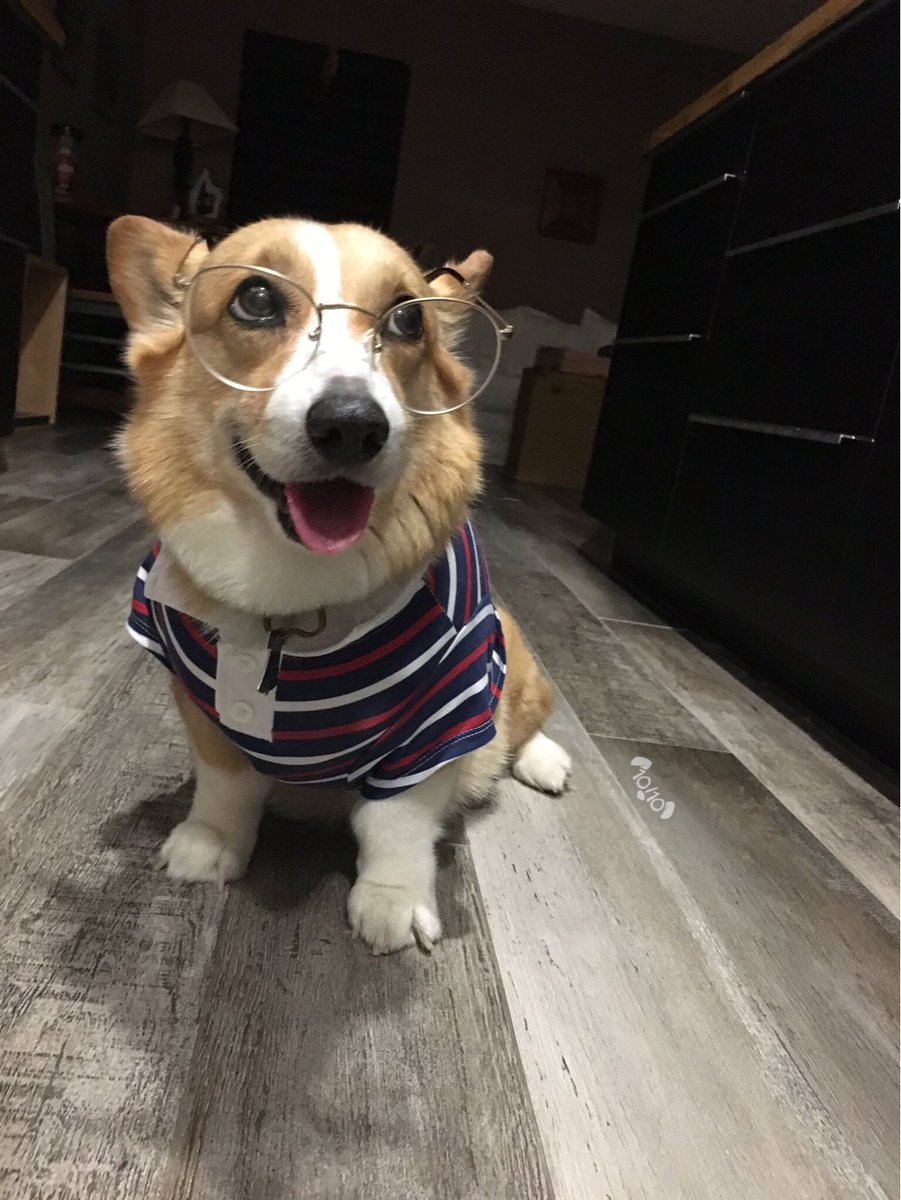

Dog name:  a
Dog breed:  Samoyed
prediction rate:  0.281463
rate:  14 / 10


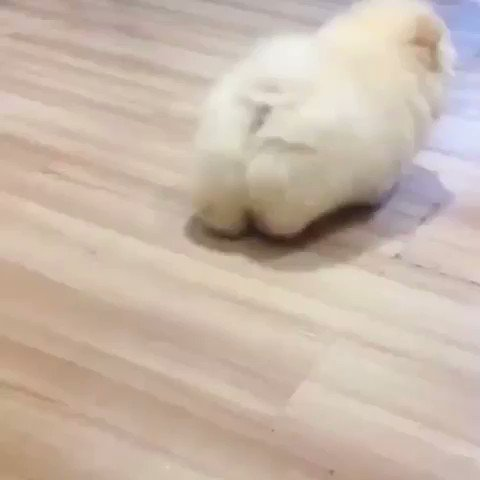

Dog name:  Emmy
Dog breed:  French_bulldog
prediction rate:  0.839097
rate:  14 / 10


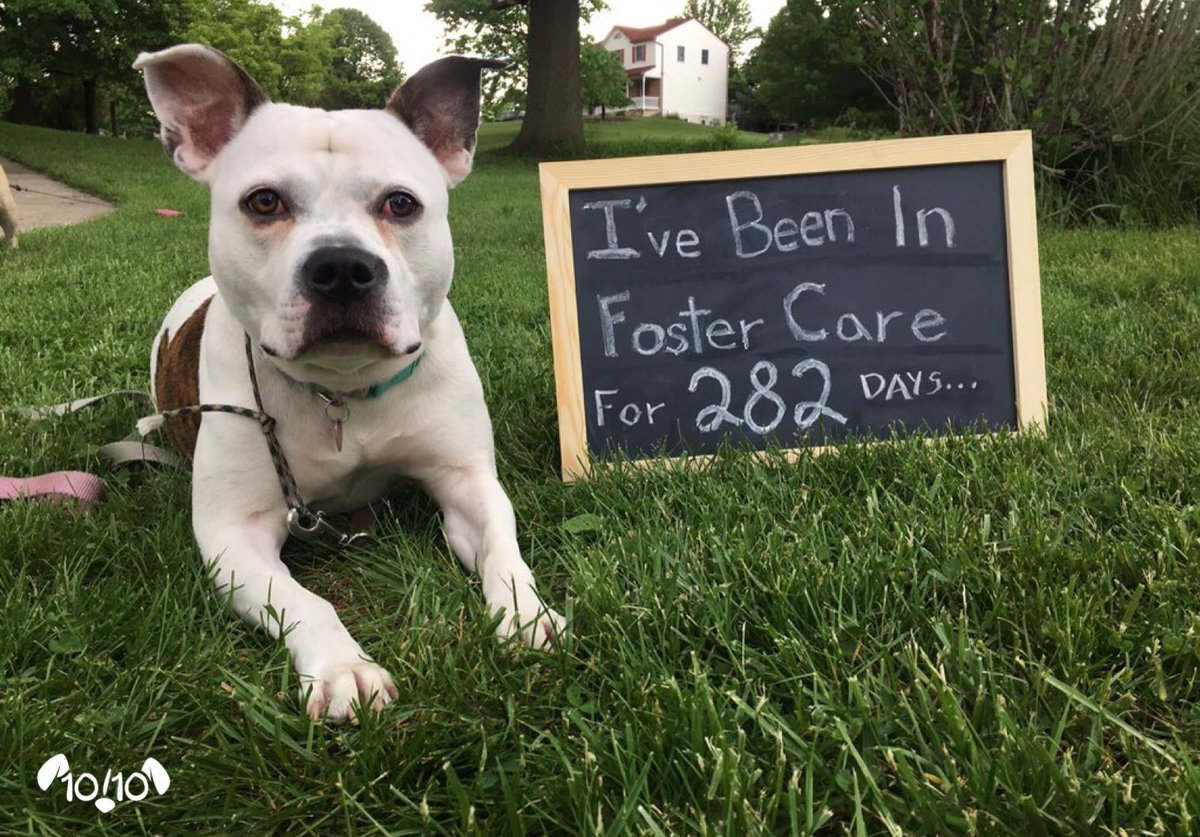

Dog name:  Cermet
Dog breed:  Chihuahua
prediction rate:  0.8765430000000001
rate:  14 / 10


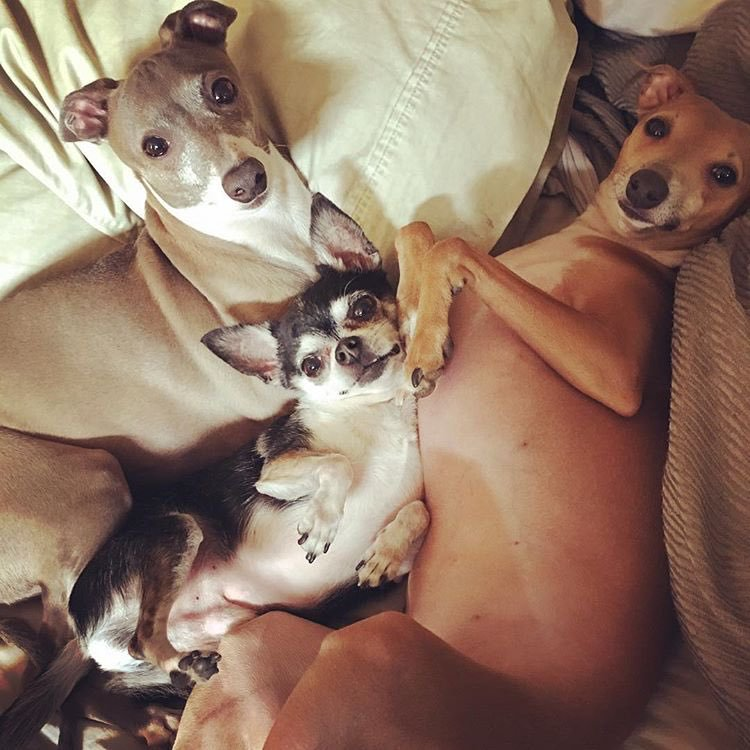

Dog name:  Smiley
Dog breed:  Pembroke
prediction rate:  0.134081
rate:  14 / 10


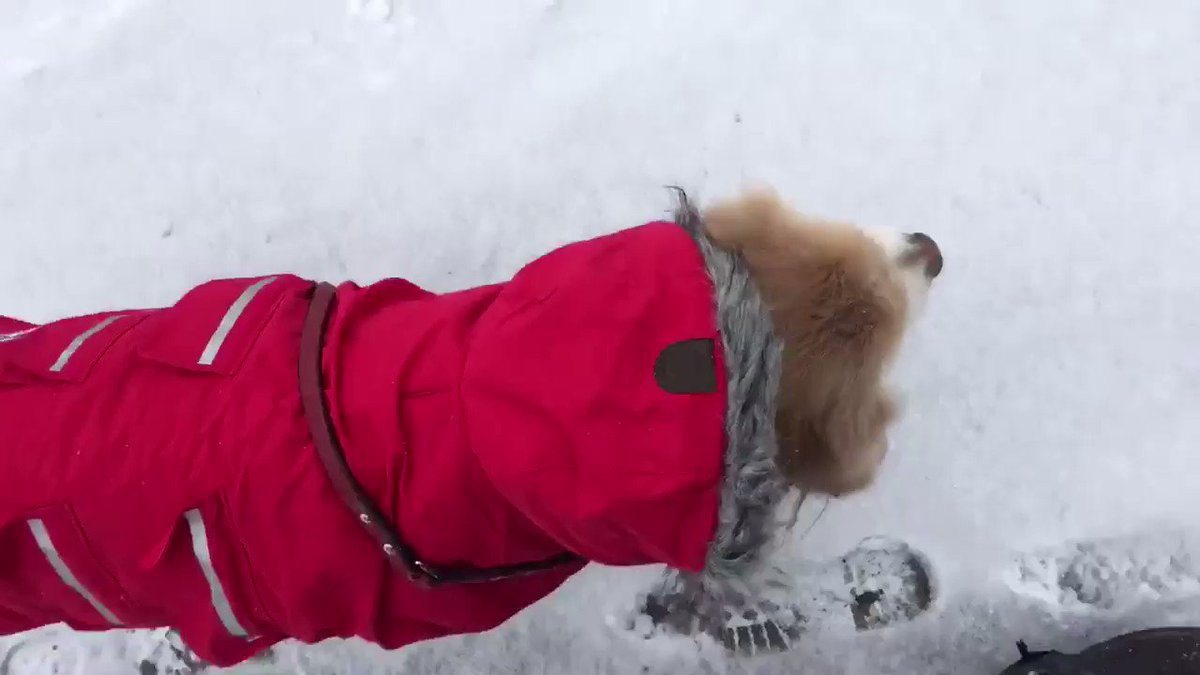

Dog name:  Kuyu
Dog breed:  bloodhound
prediction rate:  0.777562
rate:  14 / 10


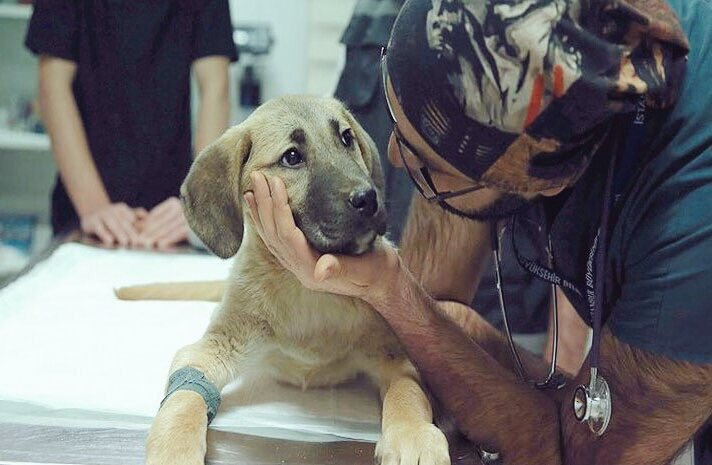

Dog name:  one
Dog breed:  golden_retriever
prediction rate:  0.649209
rate:  14 / 10


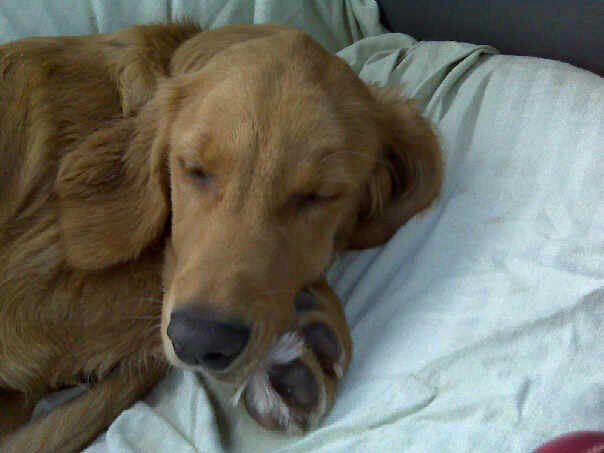

Dog name:  Doobert
Dog breed:  Bedlington_terrier
prediction rate:  0.392535
rate:  14 / 10


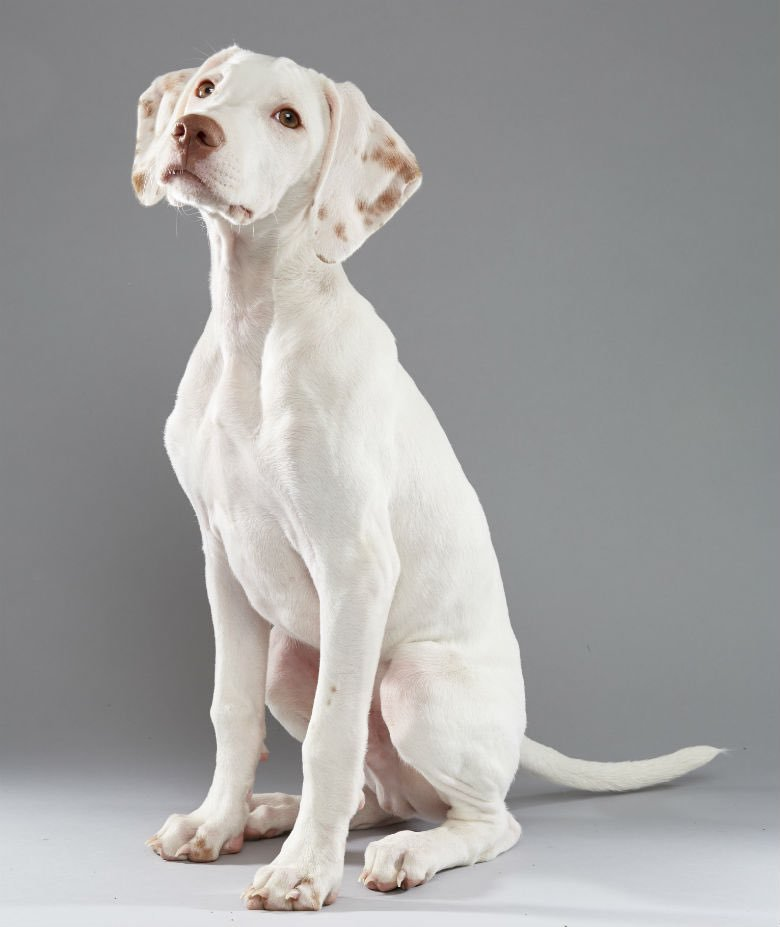

Dog name:  Gabe
Dog breed:  Pomeranian
prediction rate:  0.960199
rate:  14 / 10


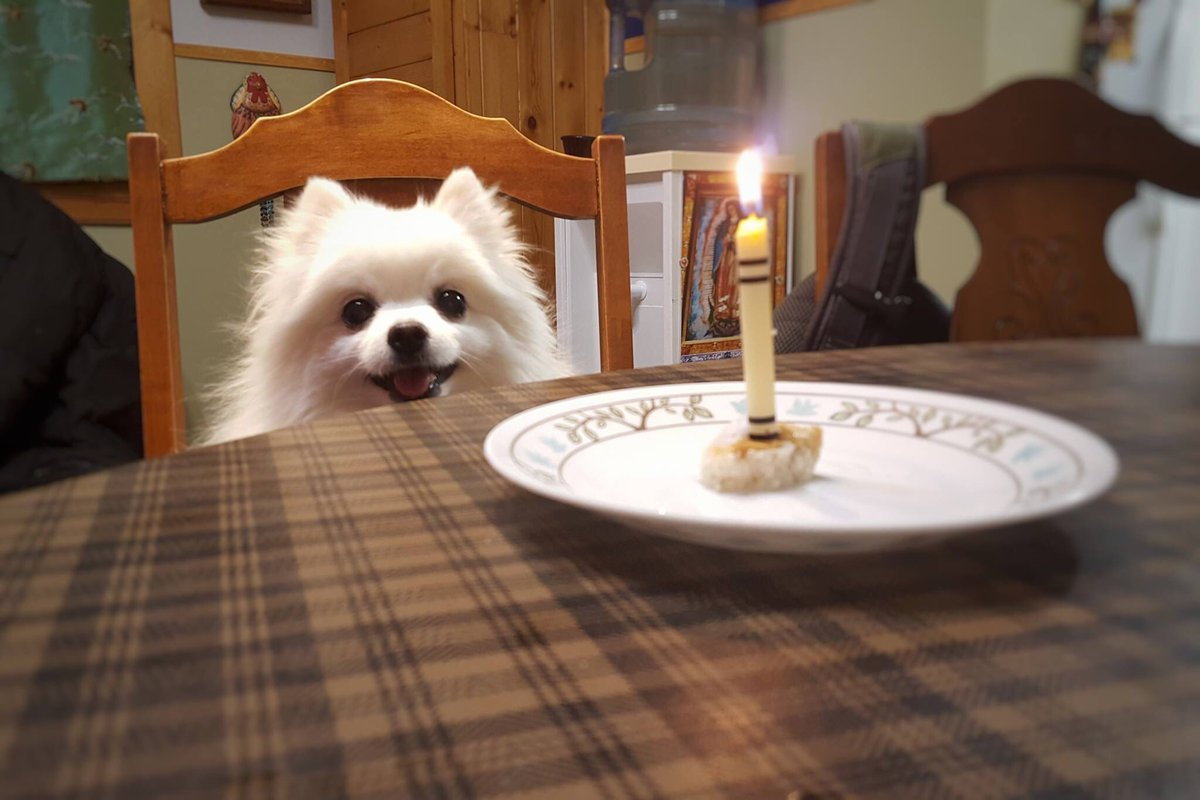

Dog name:  Sundance
Dog breed:  Irish_setter
prediction rate:  0.5054960000000001
rate:  14 / 10


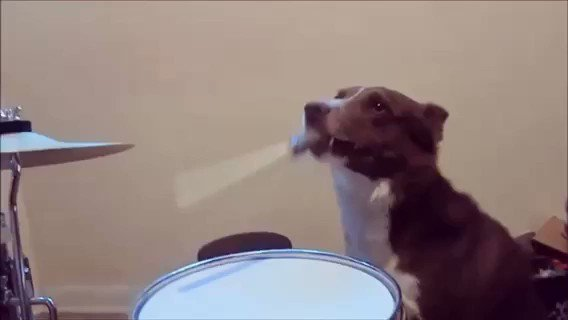

Dog name:  Bo
Dog breed:  standard_poodle
prediction rate:  0.351308
rate:  14 / 10


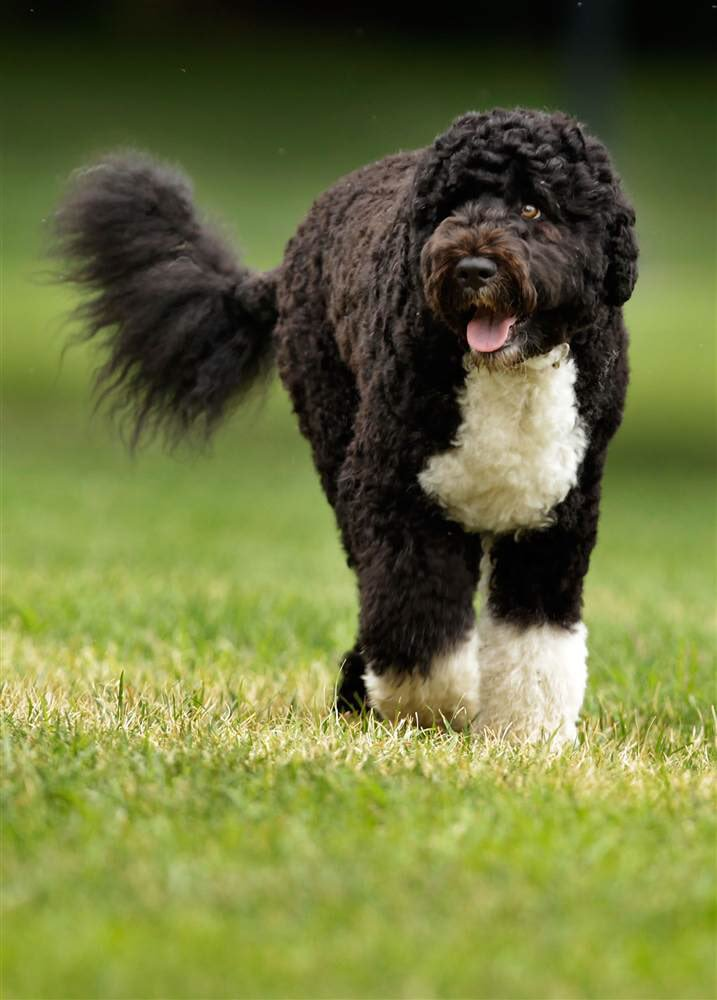

Dog name:  Gary
Dog breed:  French_bulldog
prediction rate:  0.709146
rate:  14 / 10


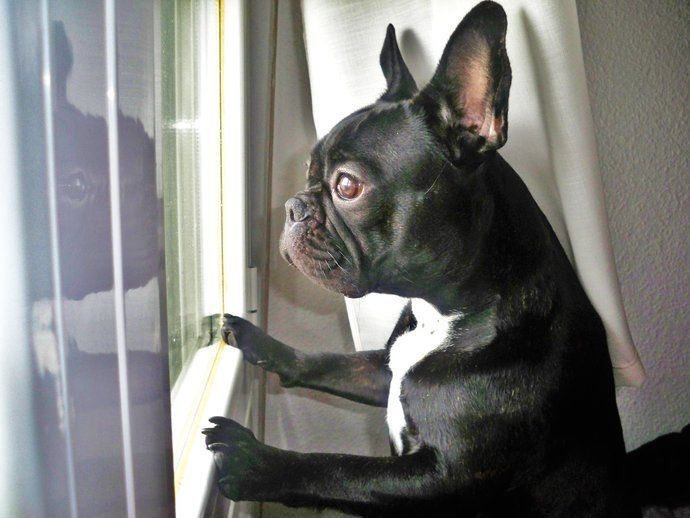

Dog name:  Ollie
Dog breed:  golden_retriever
prediction rate:  0.873233
rate:  14 / 10


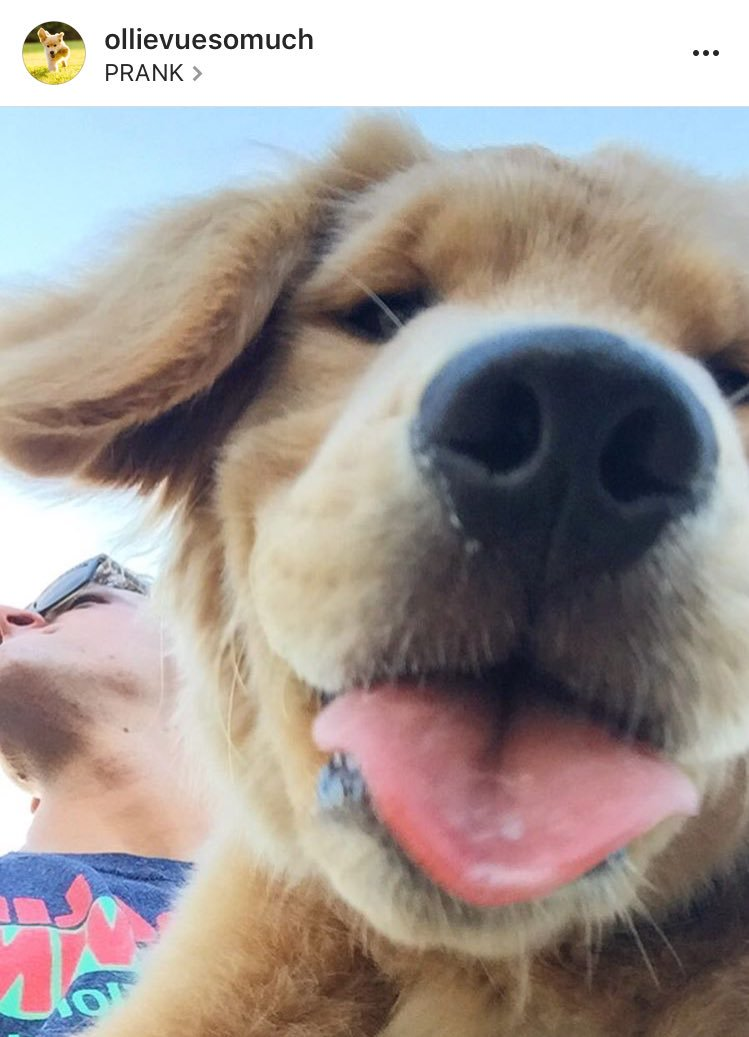

In [138]:
for dog in range(df_best_rated.shape[0]):
    dog_url = df_best_rated['jpg_url'][dog]
    print('Dog name: ', df_best_rated['name'][dog])
    print('Dog breed: ', df_best_rated['p1'][dog])
    print('prediction rate: ', df_best_rated['p1_conf'][dog])
    print('rate: ', df_best_rated['rating_numerator'][dog], '/ 10')
    display(Image(dog_url, width=400, unconfined=True))
    urllib.request.urlretrieve(dog_url, "images/best_rated_dog_"+str(dog)+".jpg")
    

### Best predicted dog breed 

The dog breed that is predicted the easiest and its amount in the dataset:

In [61]:
df_stat = pd.DataFrame(df.groupby('p1')['p1_conf'].mean())
df_stat['count'] = df.groupby('p1')['p1_conf'].count()

In [62]:
# the 10 best predicted dog breeds
df_stat.sort_values('p1_conf',ascending=False)[:10]

p1_conf  count
p1                                   
komondor              0.972531      3
Tibetan_mastiff       0.936126      2
Brittany_spaniel      0.898093      6
keeshond              0.844431      4
bull_mastiff          0.833571      4
French_bulldog        0.803971     21
Bernese_mountain_dog  0.801816     10
Samoyed               0.790475     24
Pomeranian            0.767541     27
Leonberg              0.766436      2

In [139]:
df_best_predicted = df[df['p1'] == 'komondor']
df_best_predicted = df_best_predicted.reset_index(drop=True)

Those are the dogs that belong to the best predicted breed:

Dog name:  Napolean
Dog breed:  komondor
prediction:  0.974781
rate:  12 / 10


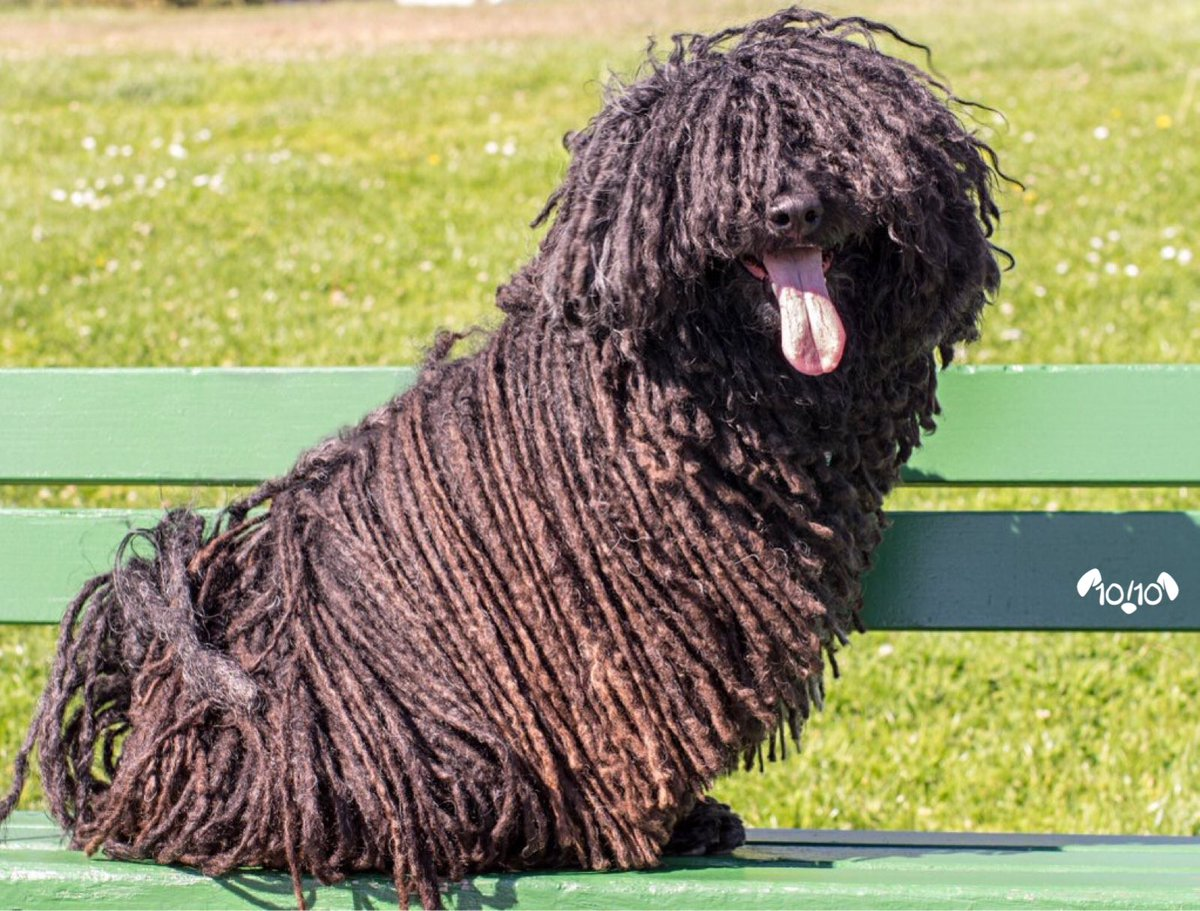

Dog name:  Remus
Dog breed:  komondor
prediction:  0.942856
rate:  11 / 10


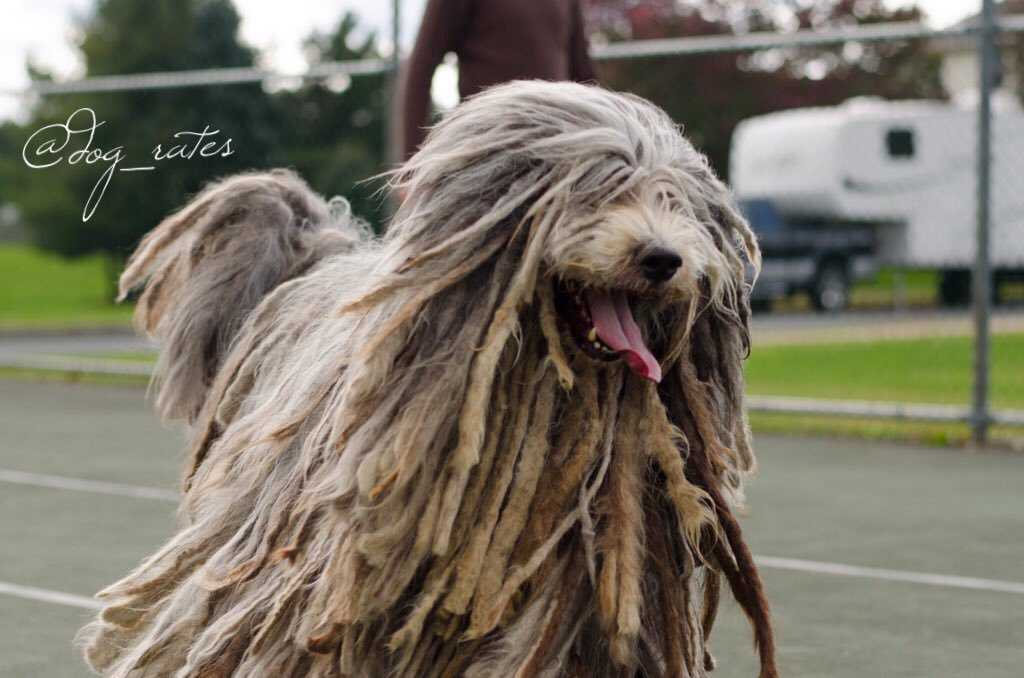

Dog name:  an
Dog breed:  komondor
prediction:  0.999956
rate:  10 / 10


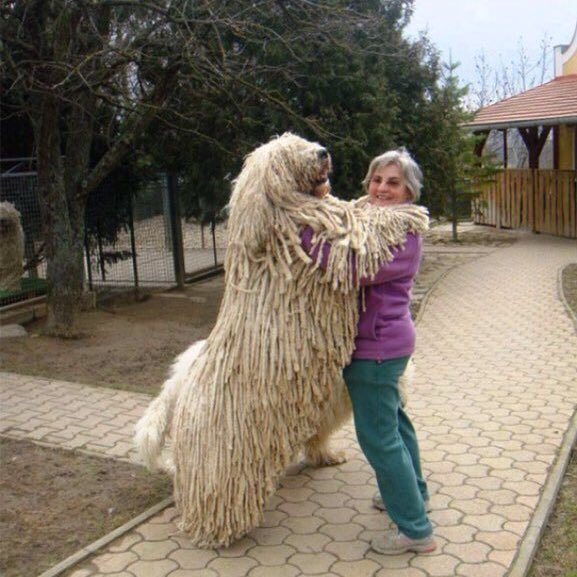

In [140]:
for dog in range(df_best_predicted.shape[0]):
    dog_url = df_best_predicted['jpg_url'][dog]
    print('Dog name: ', df_best_predicted['name'][dog])
    print('Dog breed: ', df_best_predicted['p1'][dog])
    print('prediction: ', df_best_predicted['p1_conf'][dog])
    print('rate: ', df_best_predicted['rating_numerator'][dog], '/ 10')
    display(Image(dog_url, width=400, unconfined=True))
    urllib.request.urlretrieve(dog_url, "images/best_predicted_breed_"+str(dog)+".jpg")

And here is the dog whose breed was best predicted: (also from the same breed as the best predicted breed)

In [172]:
# best predicted dog 
df_best_predicted = df[df['p1_conf'] == df['p1_conf'].max()]
df_best_predicted = df_best_predicted.reset_index(drop=True)
df_best_predicted.shape

(1, 24)

Dog name:  an
Dog breed:  komondor
prediction:  0.999956
rate:  10 / 10
retweet:  496
favorite:  1040


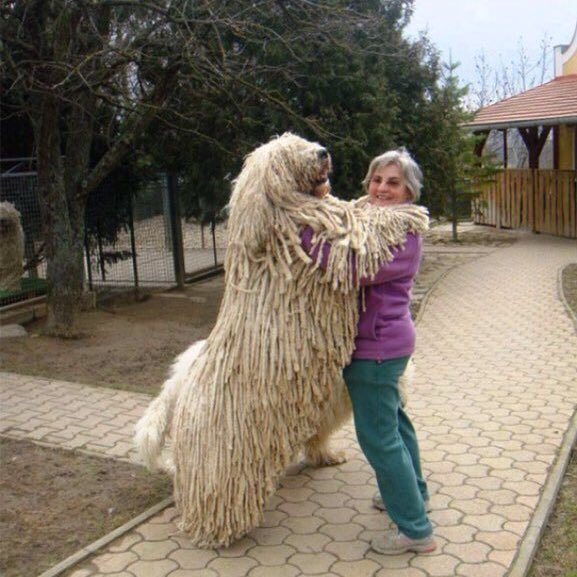

In [197]:
for dog in range(df_best_predicted.shape[0]):
    dog_url = df_best_predicted['jpg_url'][dog]
    print('Dog name: ', df_best_predicted['name'][dog])
    print('Dog breed: ', df_best_predicted['p1'][dog])
    print('prediction: ', df_best_predicted['p1_conf'][dog])
    print('rate: ', df_best_predicted['rating_numerator'][dog], '/ 10')
    print('retweet: ', df_best_predicted['retweet_count'][dog])
    print('favorite: ', df_best_predicted['favorite_count'][dog])
    display(Image(dog_url, width=400, unconfined=True))
    urllib.request.urlretrieve(dog_url, "images/best_predicted_breed_"+str(dog)+".jpg")

### Most rated dog breed
The 10 most rated dog breeds:

In [65]:
df_stat.sort_values('count',ascending=False)[:10]

p1_conf  count
p1                                 
golden_retriever    0.730279     95
Pembroke            0.715845     68
Labrador_retriever  0.645026     65
Chihuahua           0.592743     60
pug                 0.745156     42
chow                0.631058     34
toy_poodle          0.588837     32
Pomeranian          0.767541     27
Samoyed             0.790475     24
malamute            0.570732     23

In [141]:
df_most_rated = df[df['p1'] == 'golden_retriever']
df_most_rated = df_most_rated.reset_index(drop=True)
df_most_rated.shape

(95, 24)

Let's look at 10 dogs of the most rated breed in the dataset-the golden retriever:

Dog name:  Stuart
Dog breed:  golden_retriever
prediction rate:  0.953442
rate:  13 / 10


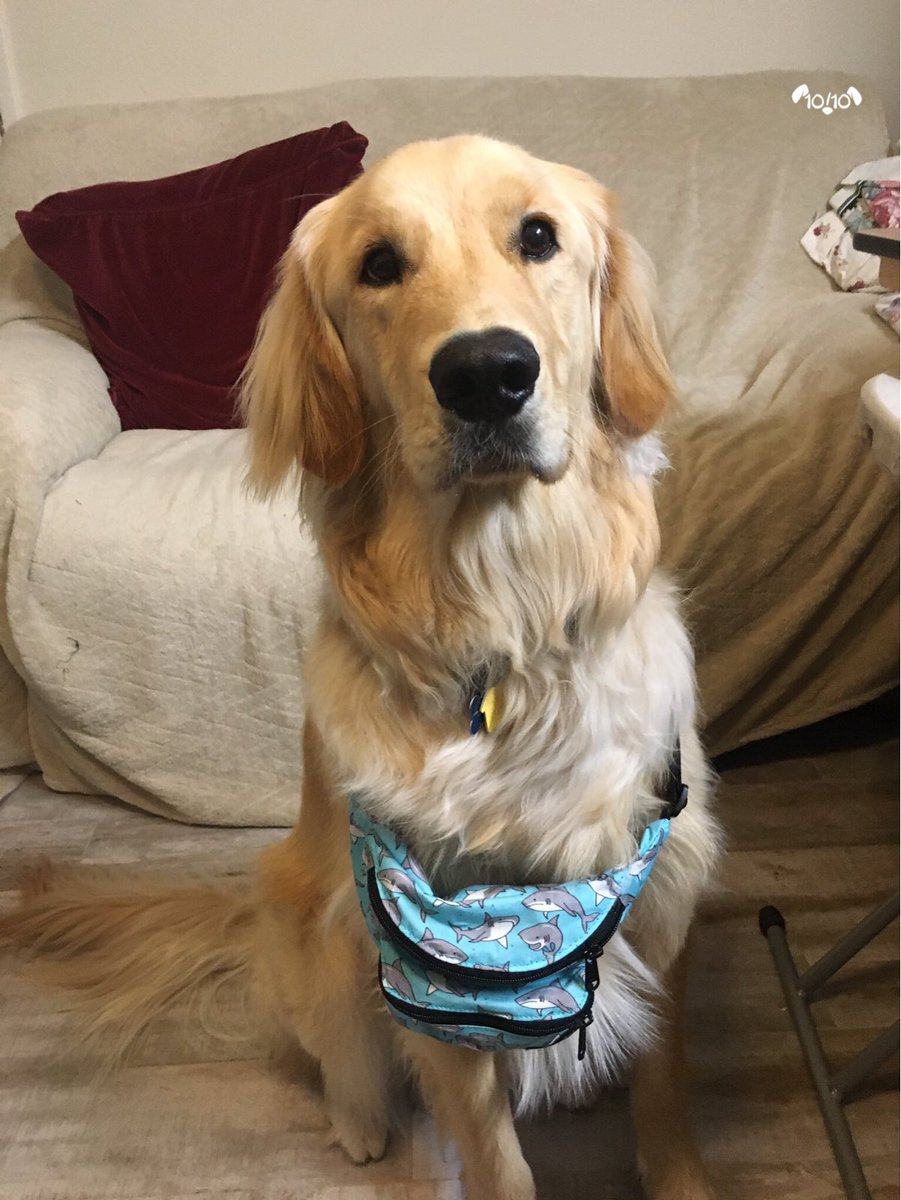

Dog name:  Jim
Dog breed:  golden_retriever
prediction rate:  0.714719
rate:  12 / 10


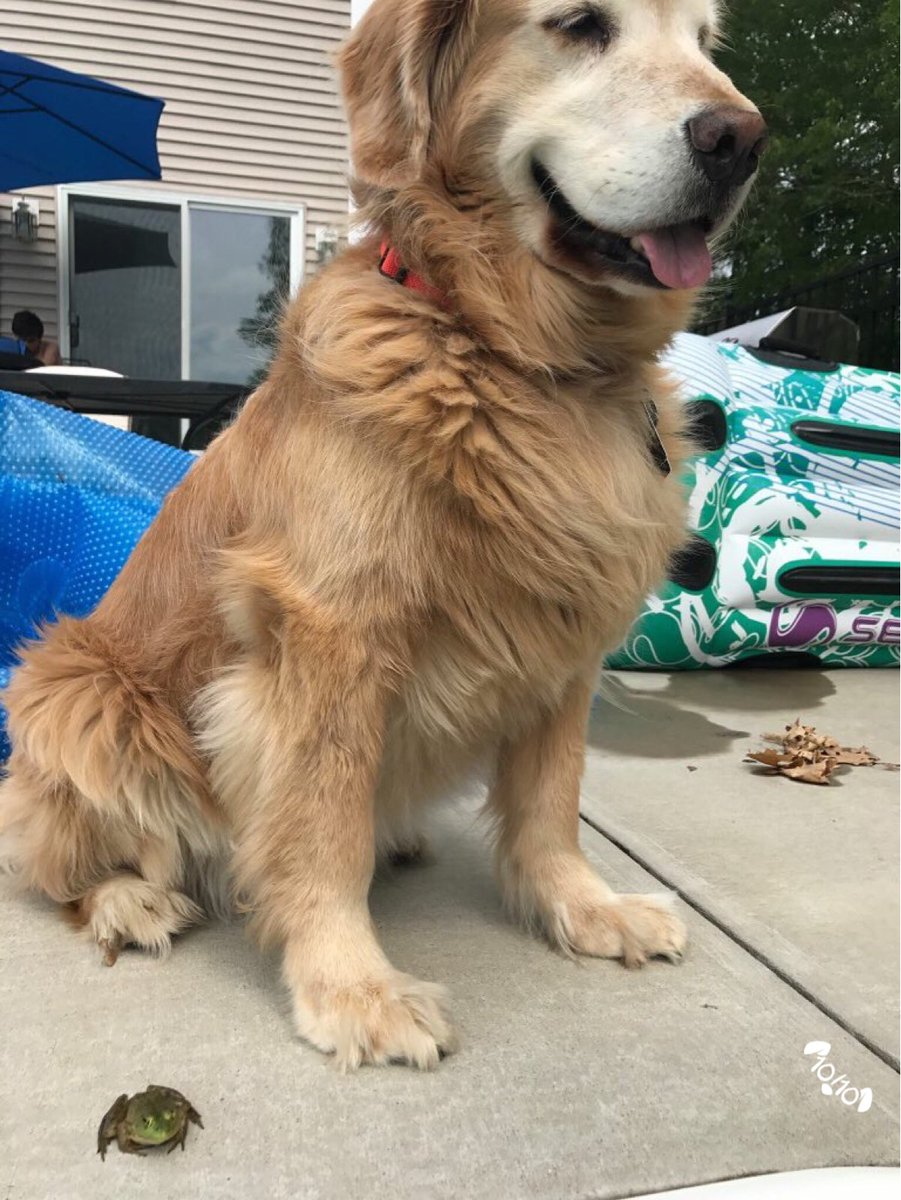

Dog name:  Zeke
Dog breed:  golden_retriever
prediction rate:  0.46976
rate:  13 / 10


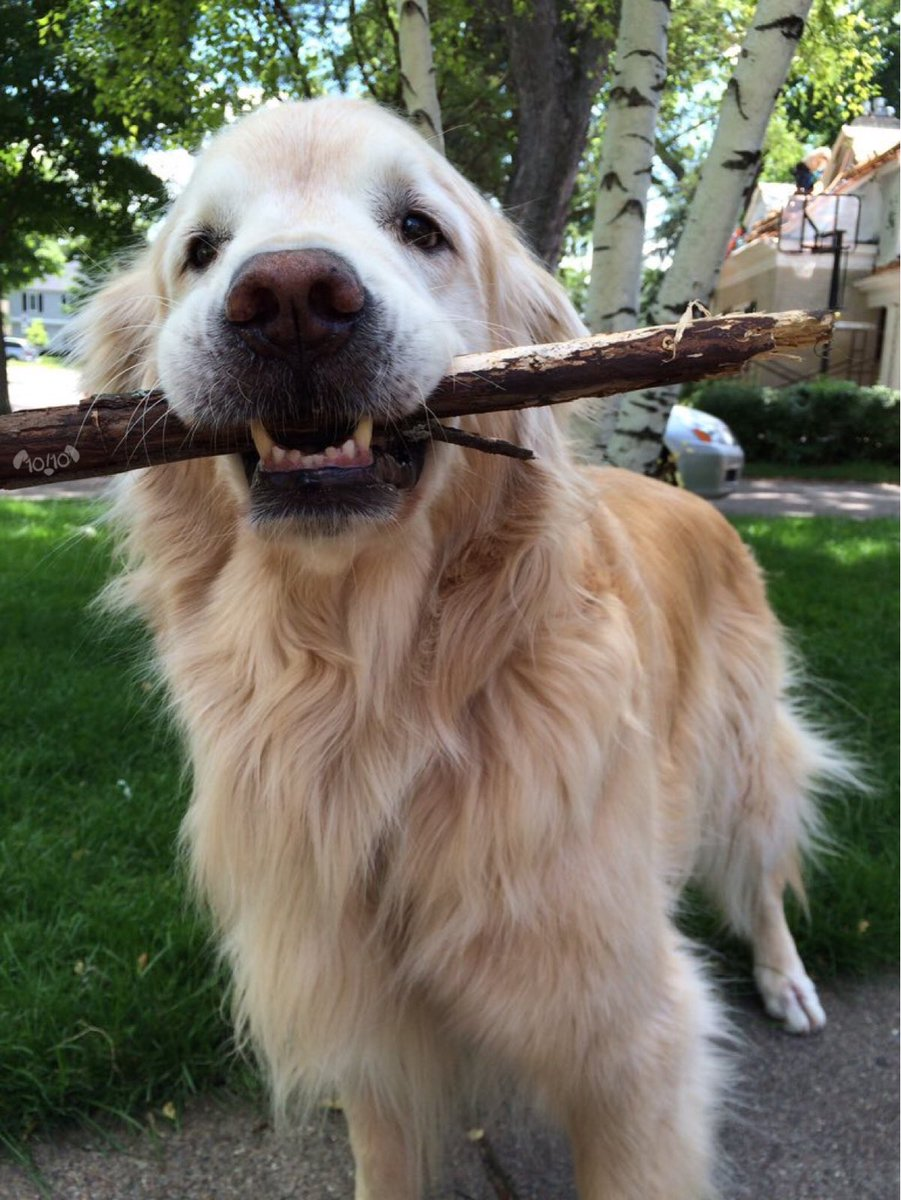

Dog name:  Bella
Dog breed:  golden_retriever
prediction rate:  0.943082
rate:  5 / 10


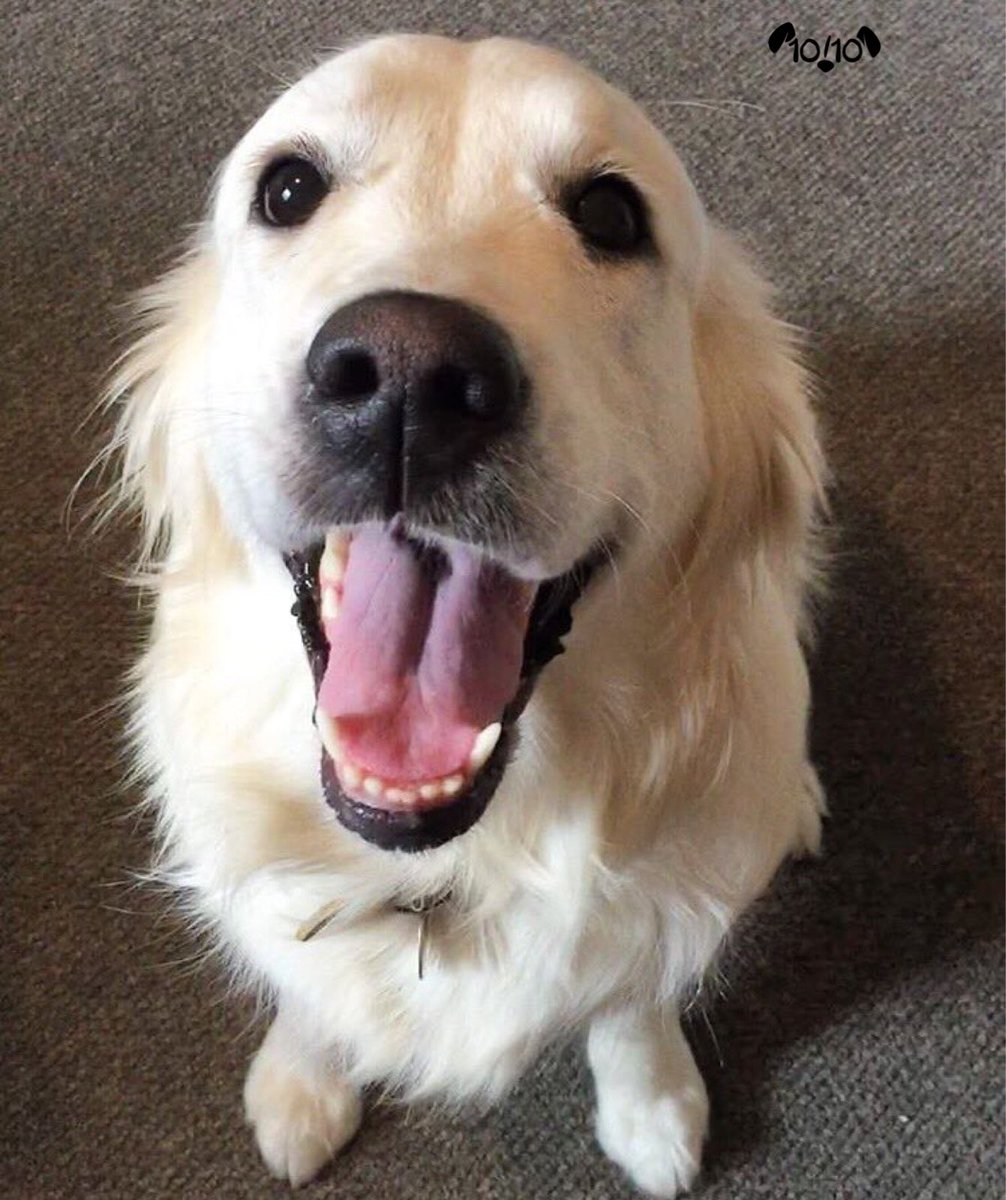

Dog name:  Alfy
Dog breed:  golden_retriever
prediction rate:  0.762211
rate:  13 / 10


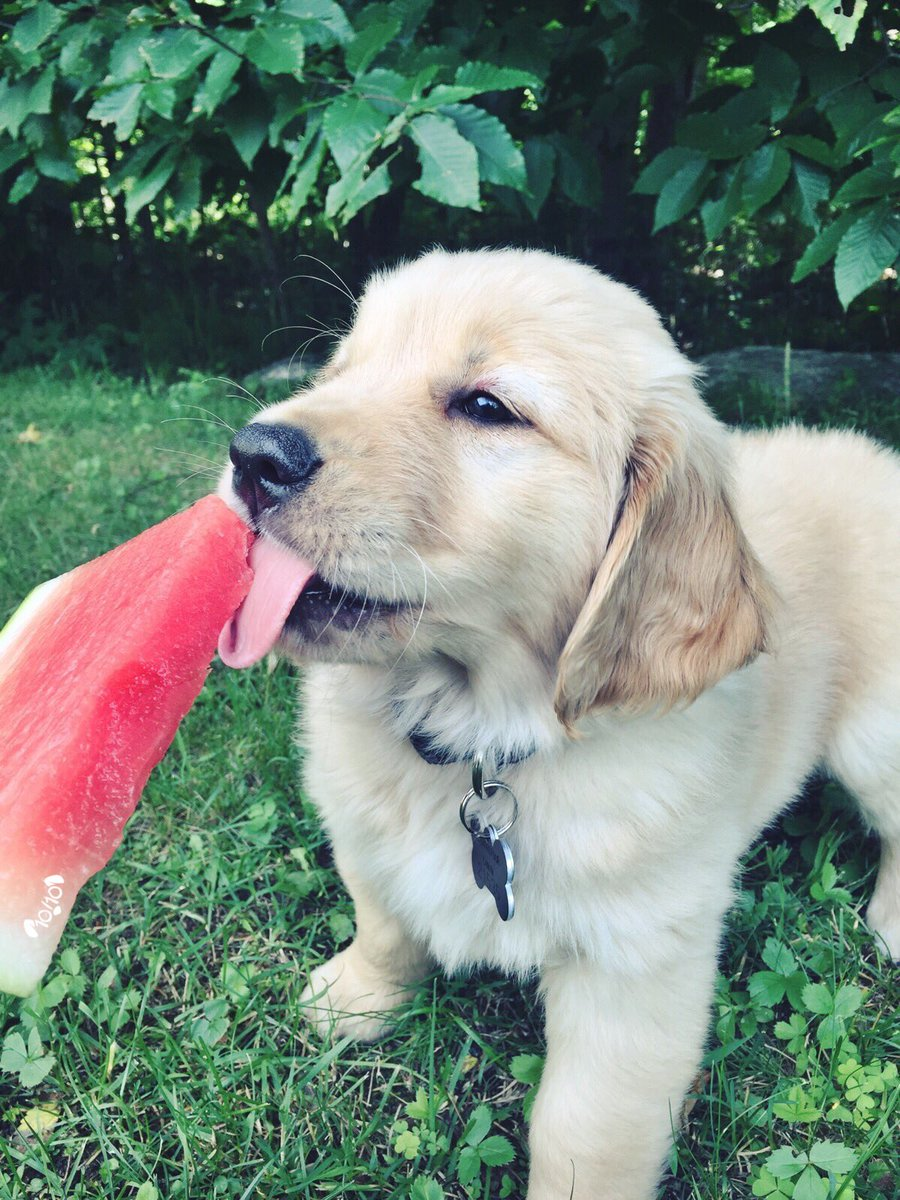

Dog name:  Bella
Dog breed:  golden_retriever
prediction rate:  0.913255
rate:  12 / 10


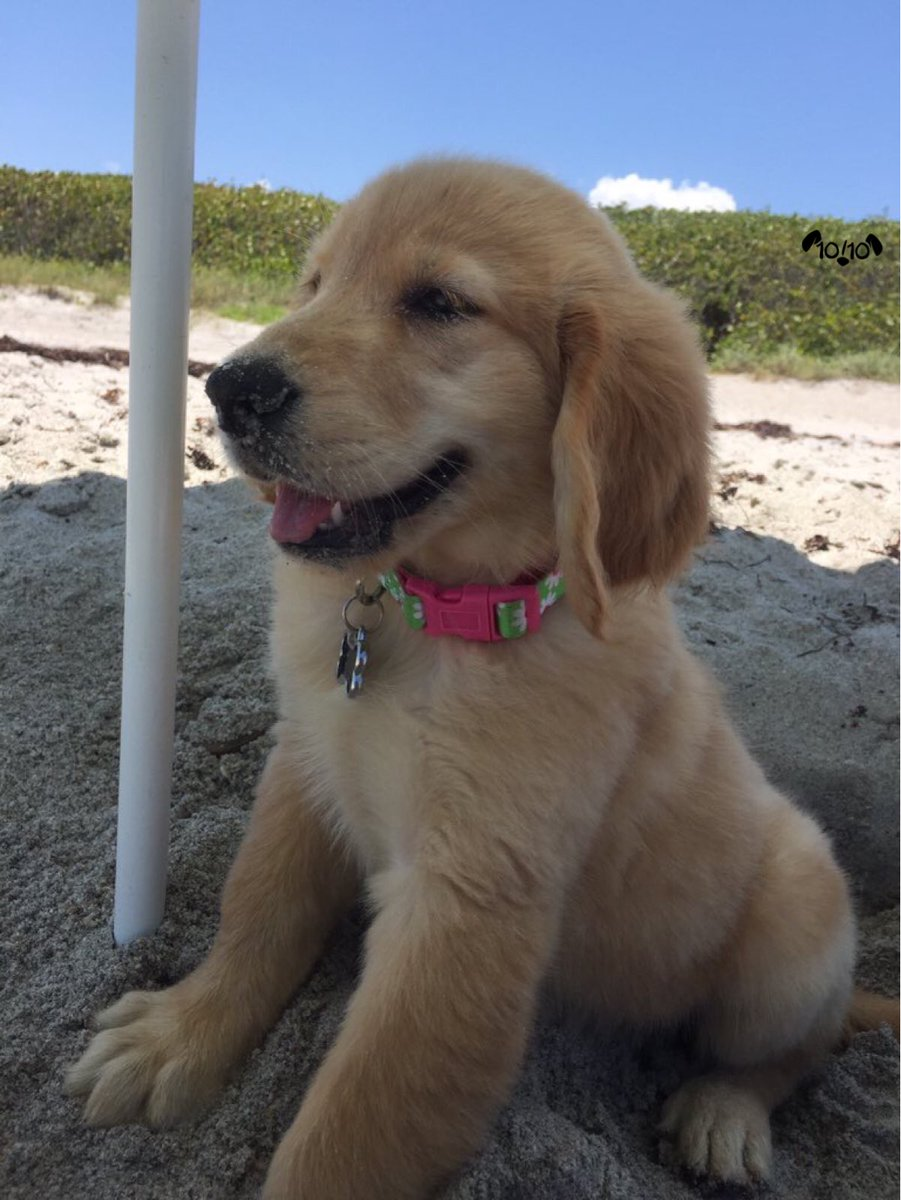

Dog name:  Benedict
Dog breed:  golden_retriever
prediction rate:  0.874566
rate:  13 / 10


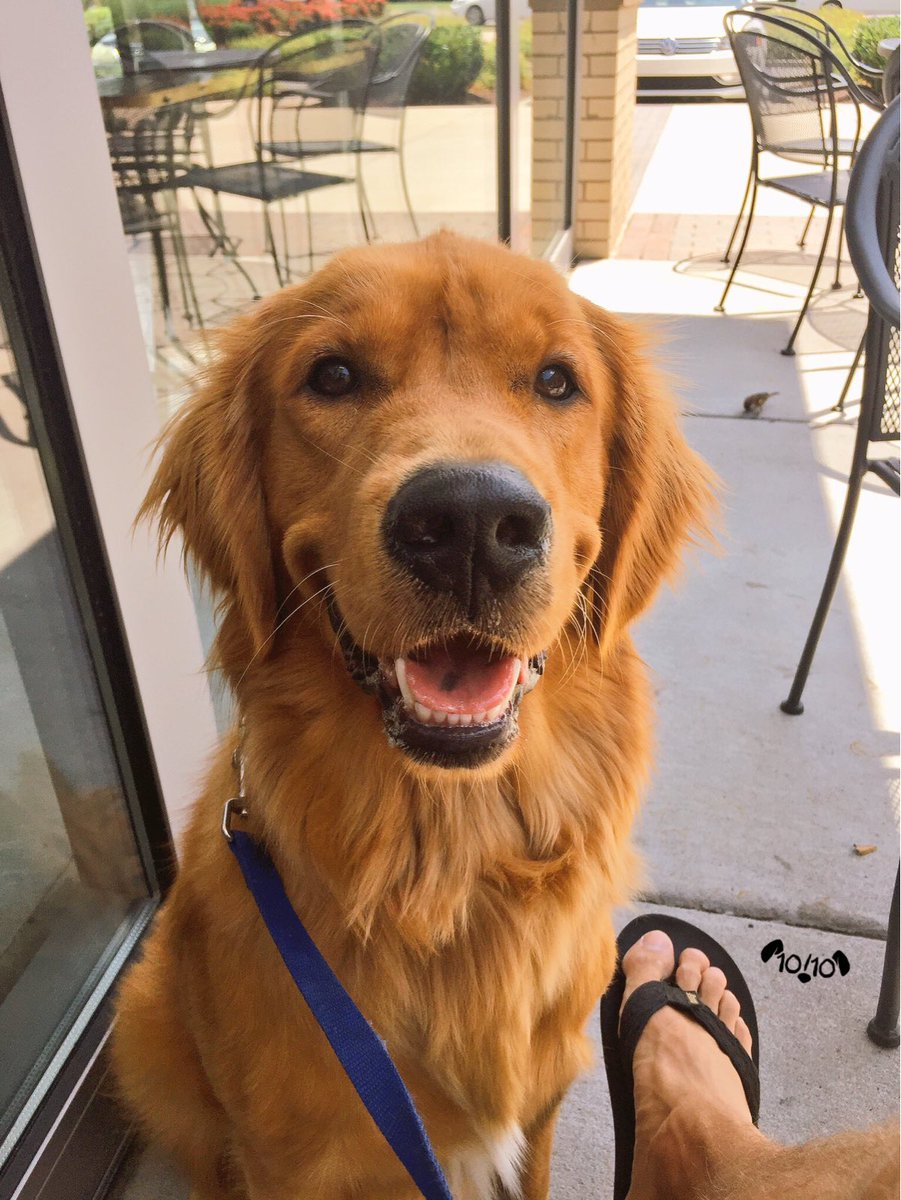

Dog name:  Zoey
Dog breed:  golden_retriever
prediction rate:  0.841001
rate:  13 / 10


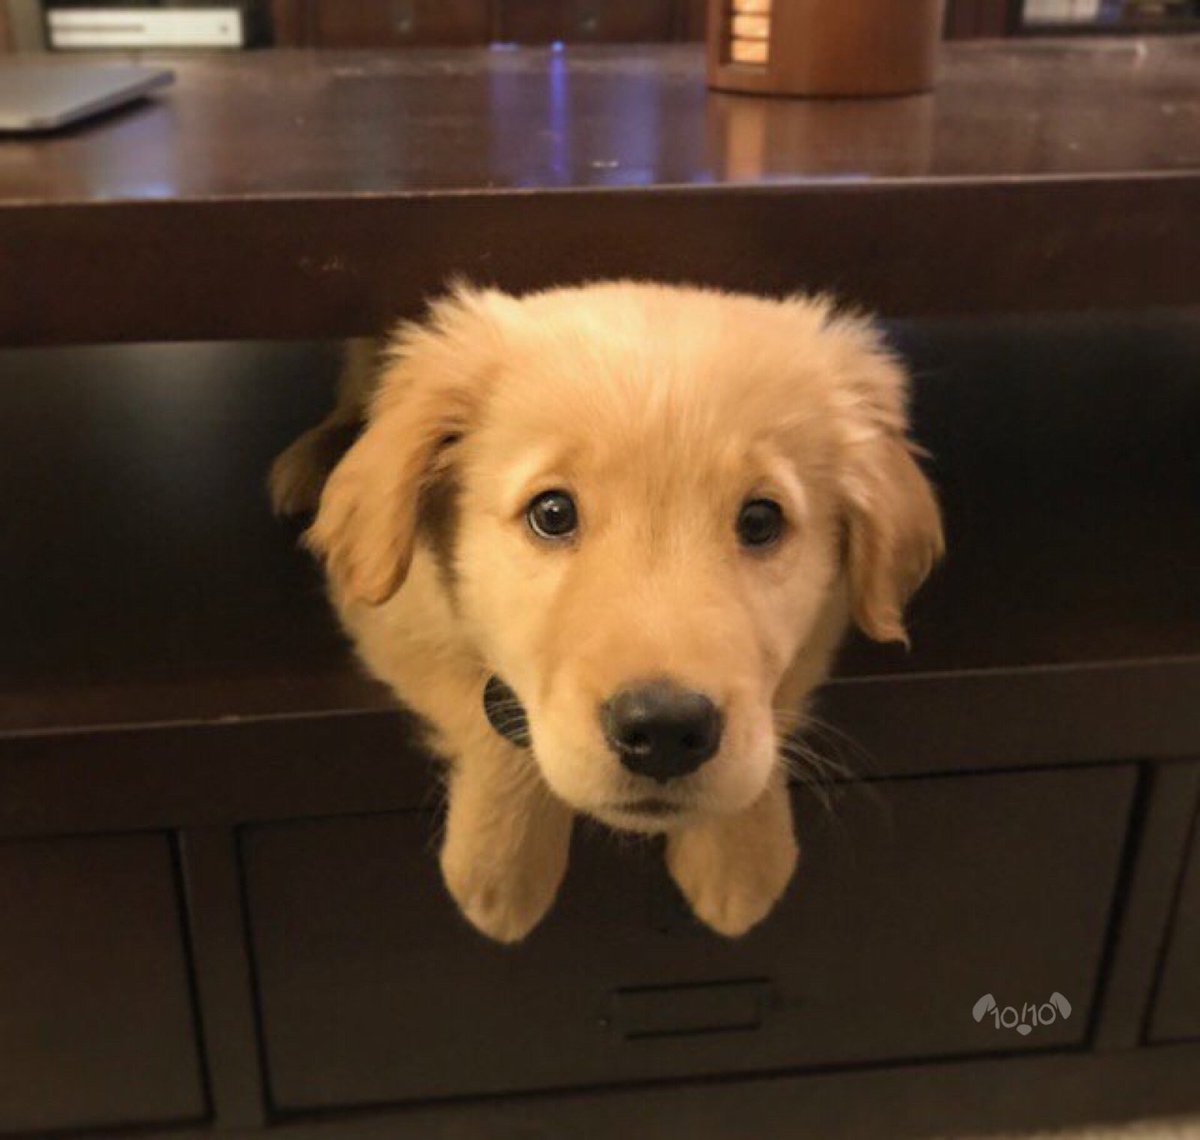

Dog name:  Boomer
Dog breed:  golden_retriever
prediction rate:  0.673664
rate:  13 / 10


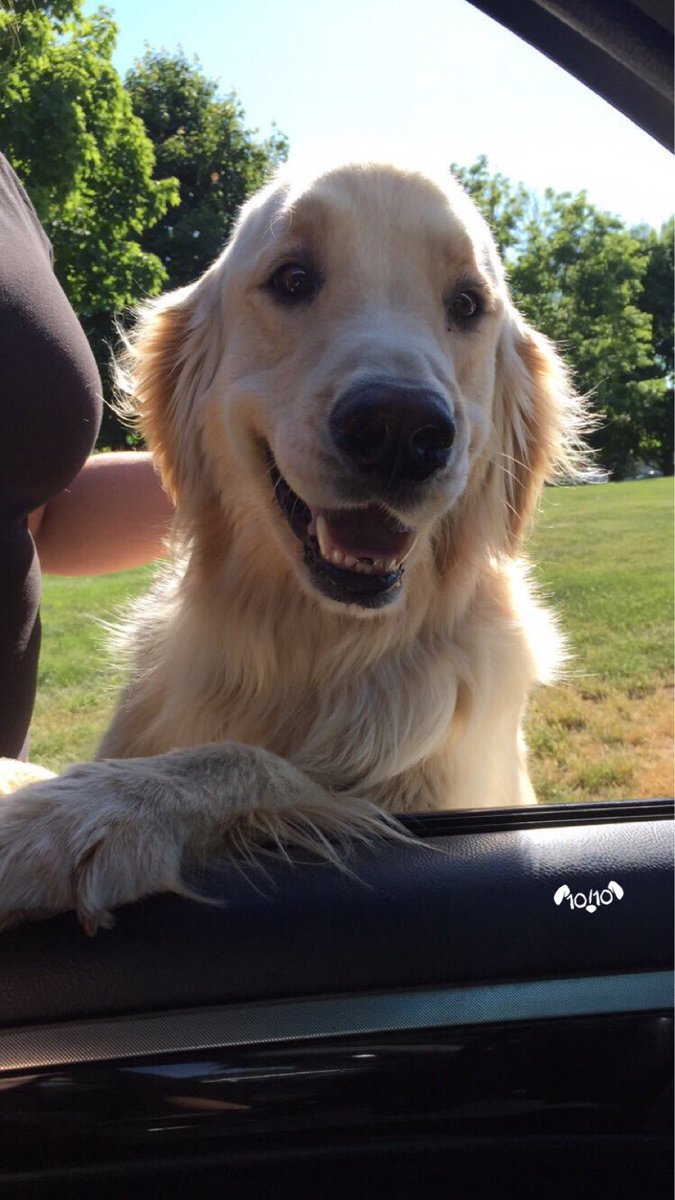

Dog name:  Paisley
Dog breed:  golden_retriever
prediction rate:  0.945905
rate:  13 / 10


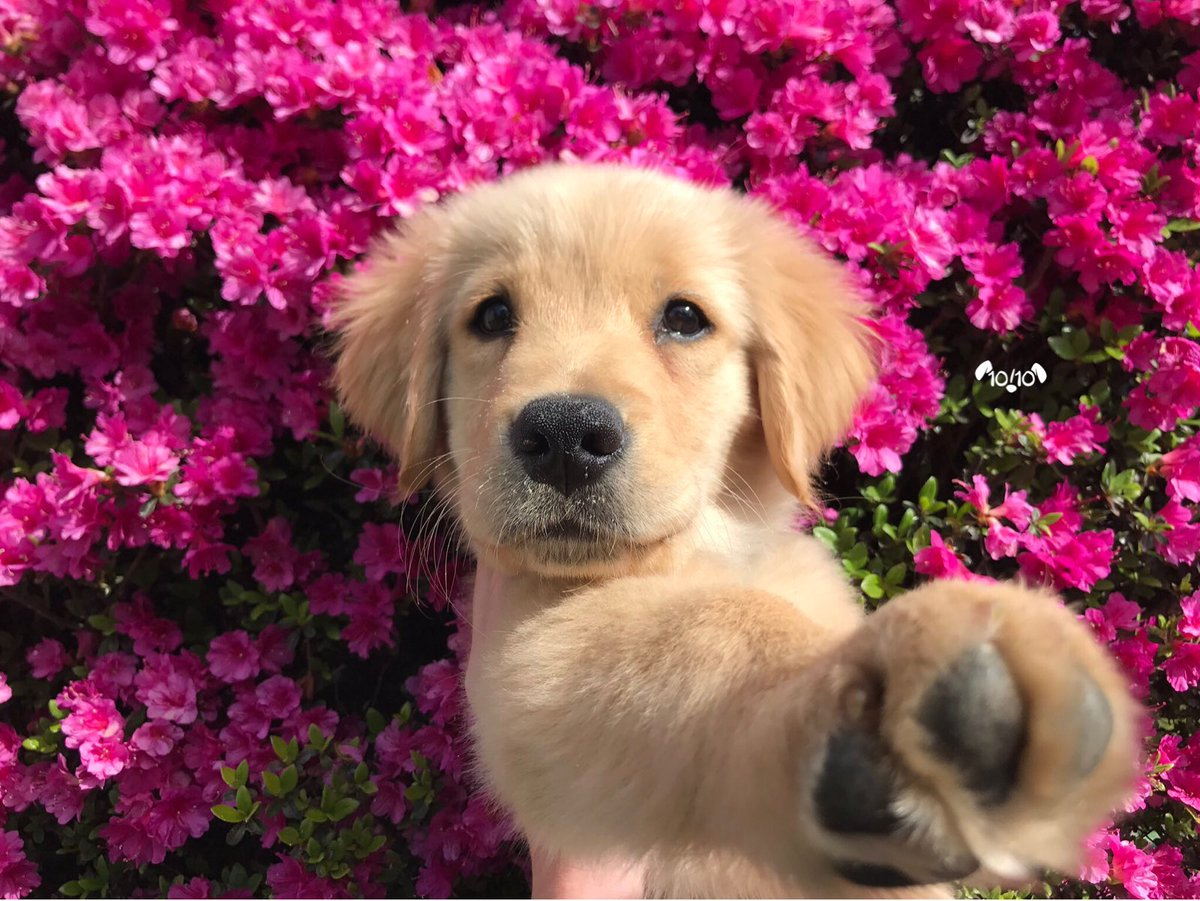

In [142]:
# show only 10 of 95 dogs
for dog in range(10):
    dog_url = df_most_rated['jpg_url'][dog]
    print('Dog name: ', df_most_rated['name'][dog])
    print('Dog breed: ', df_most_rated['p1'][dog])
    print('prediction rate: ', df_most_rated['p1_conf'][dog])
    print('rate: ', df_most_rated['rating_numerator'][dog], '/ 10')
    display(Image(dog_url, width=400, unconfined=True))
    urllib.request.urlretrieve(dog_url, "images/most_rated_breed"+str(dog)+".jpg")

### most favored dog
The most favored dog from twitter favorite counts:

In [164]:
df_most_favorited = df[df['favorite_count'] == df['favorite_count'].max()]
df_most_favorited = df_most_favorited.reset_index(drop=True)
df_most_favorited.shape

(1, 24)

Dog name:  Stephan
Dog breed:  Chihuahua
favorited:  125519
prediction rate:  0.953442
rate:  13 / 10
retweet:  60236
favorite:  125519


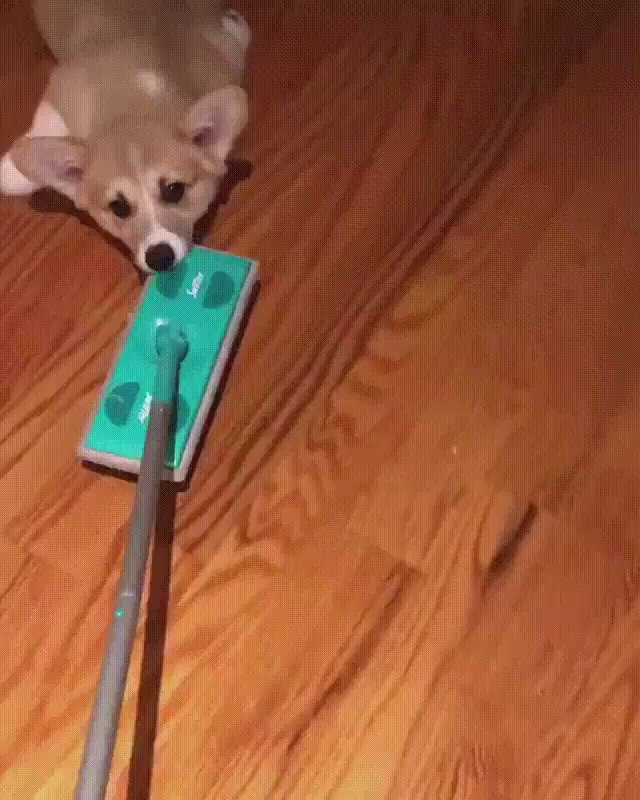

In [200]:
for dog in range(df_most_favorited.shape[0]):
    dog_url = df_most_favorited['jpg_url'][dog]
    print('Dog name: ', df_most_favorited['name'][dog])
    print('Dog breed: ', df_most_favorited['p1'][dog])
    print('favorited: ', df_most_favorited['favorite_count'][dog])
    print('prediction rate: ', df_most_rated['p1_conf'][dog])
    print('rate: ', df_most_favorited['rating_numerator'][dog], '/ 10')
    print('retweet: ', df_most_favorited['retweet_count'][dog])
    print('favorite: ', df_most_favorited['favorite_count'][dog])
    display(Image(dog_url, width=400, unconfined=True))
    urllib.request.urlretrieve(dog_url, "images/df_most_favorited_"+str(dog)+".jpg")

How close are the other dogs with their favorite counts? Therefore we look at the histogram of the favorite counts:

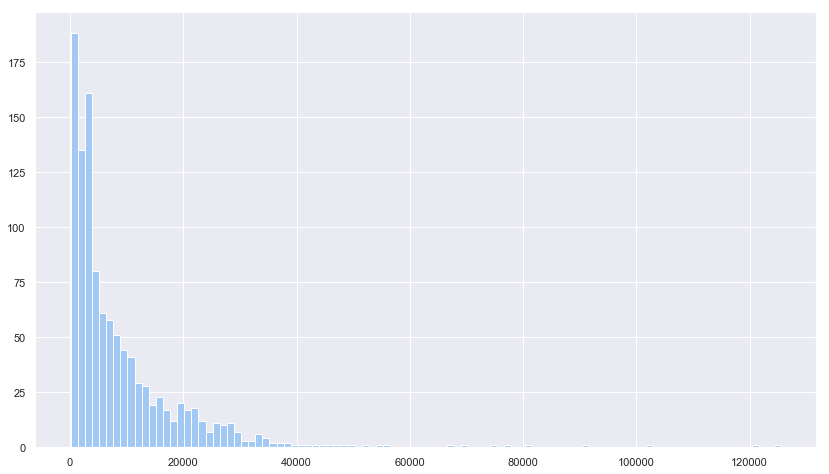

In [194]:
df['favorite_count'].hist(bins=100)

### most retweeted dog

Who is the most retweeded dog?

In [167]:
df_most_retweeted = df[df['retweet_count'] == df['retweet_count'].max()]
df_most_retweeted = df_most_retweeted.reset_index(drop=True)
df_most_retweeted.shape

(1, 24)

Dog name:  Stephan
Dog breed:  Chihuahua
favorited:  125519
rate:  13 / 10


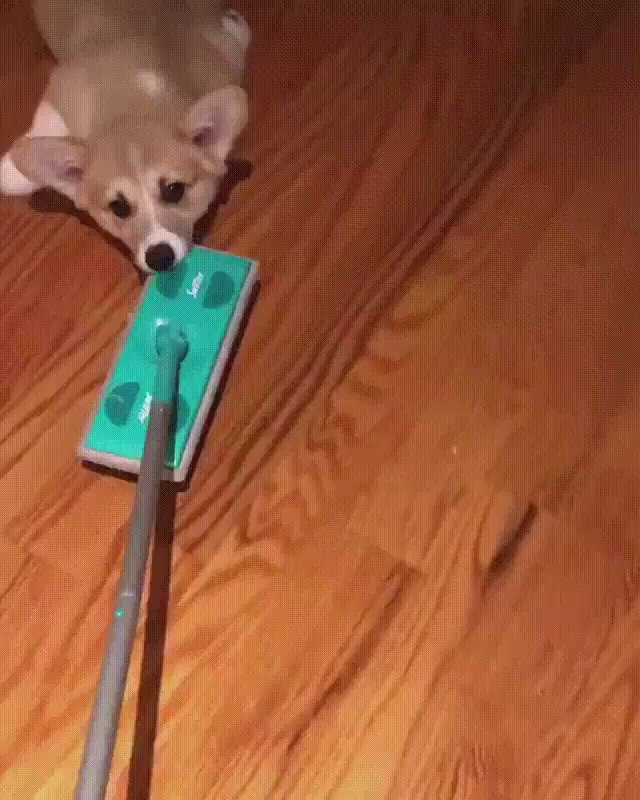

In [168]:
for dog in range(df_most_retweeted.shape[0]):
    dog_url = df_most_retweeted['jpg_url'][dog]
    print('Dog name: ', df_most_retweeted['name'][dog])
    print('Dog breed: ', df_most_retweeted['p1'][dog])
    print('favorited: ', df_most_retweeted['favorite_count'][dog])
    print('rate: ', df_most_retweeted['rating_numerator'][dog], '/ 10')
    display(Image(dog_url, width=400, unconfined=True))
    urllib.request.urlretrieve(dog_url, "images/df_most_retweeted_"+str(dog)+".jpg")

### Visualization

In [241]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(20,12)})
sns.set(font_scale=2.0)
sns.set_palette("pastel")

### Used dog vocabularies

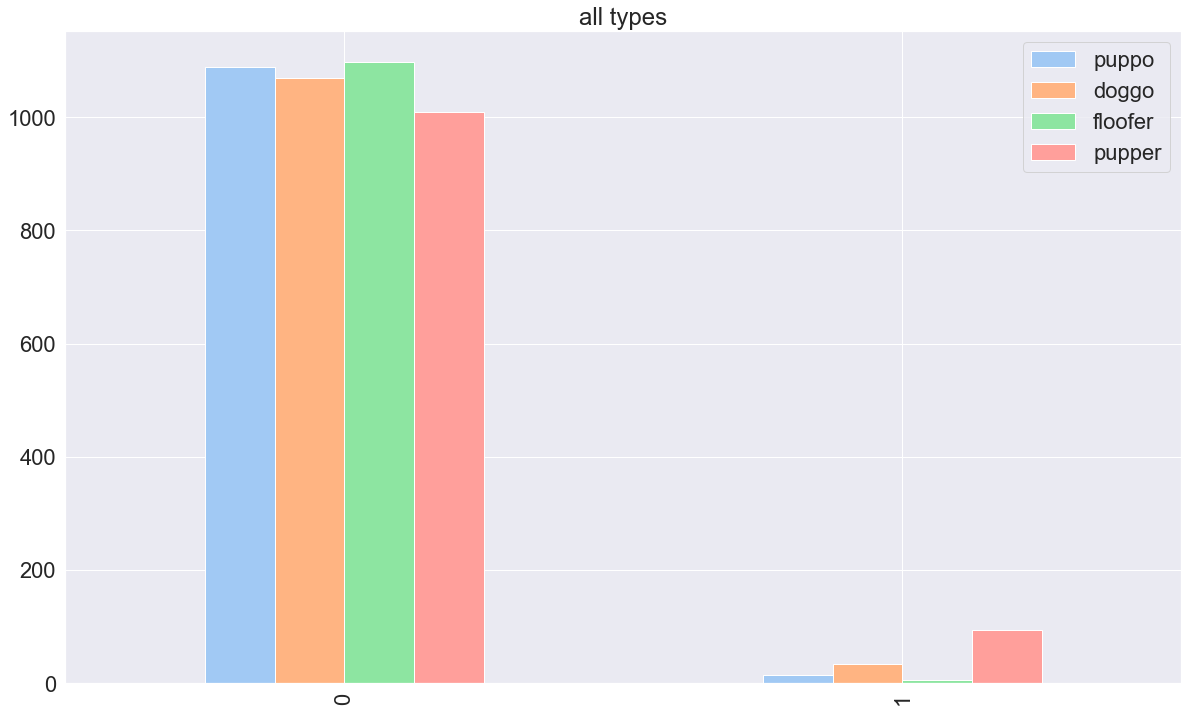

In [242]:
df_words = df[['puppo', 'doggo', 'floofer', 'pupper']]
df_words.apply(pd.value_counts).plot(kind='bar', 
                                     title='all types')
fig = ax.get_figure()
fig.savefig("plots/dog_vocabularies.png")

### Ratings over time (colored by retweet count)

In [243]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

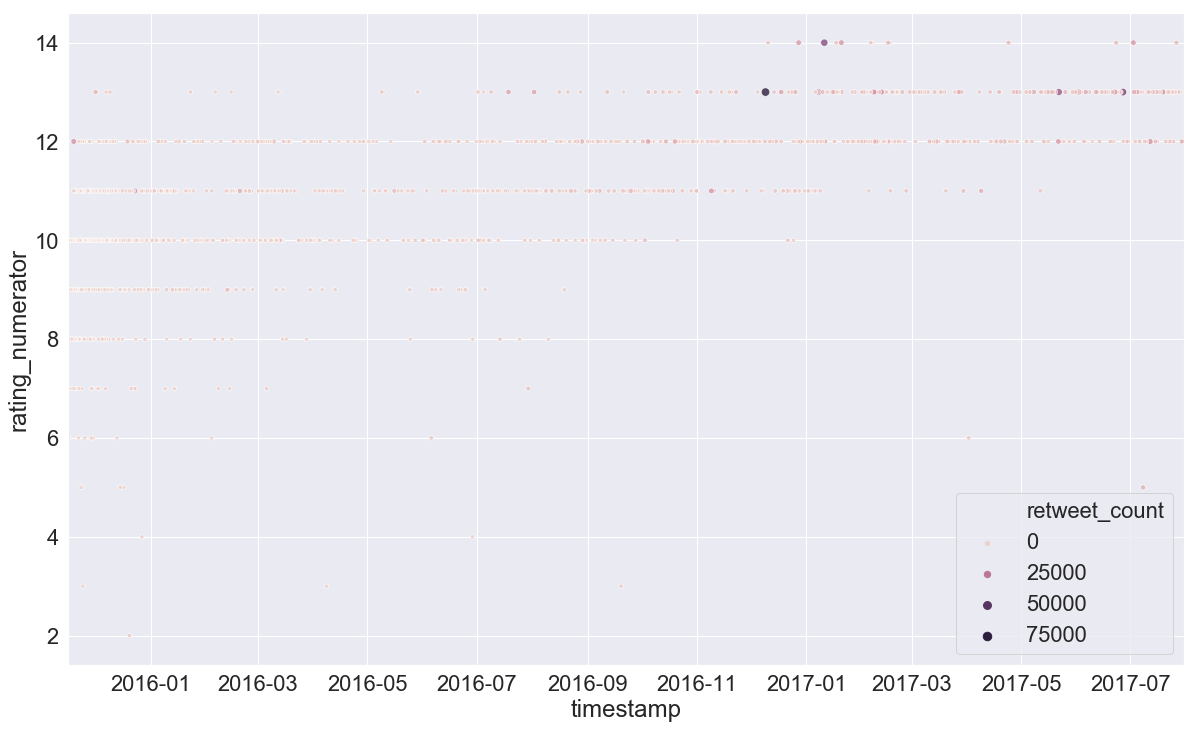

In [244]:
ax = sns.scatterplot(x="timestamp", y="rating_numerator",
                      hue="retweet_count", size="retweet_count",alpha=.8,
                      data=df)

ax.set_xlim(df['timestamp'].min(), df['timestamp'].max())
fig = ax.get_figure()
fig.savefig("plots/retweet_rating_over_time_b.png")

The ratings have changed over time. The ratings have increased.

### Ratings over time (colored by favorite count)

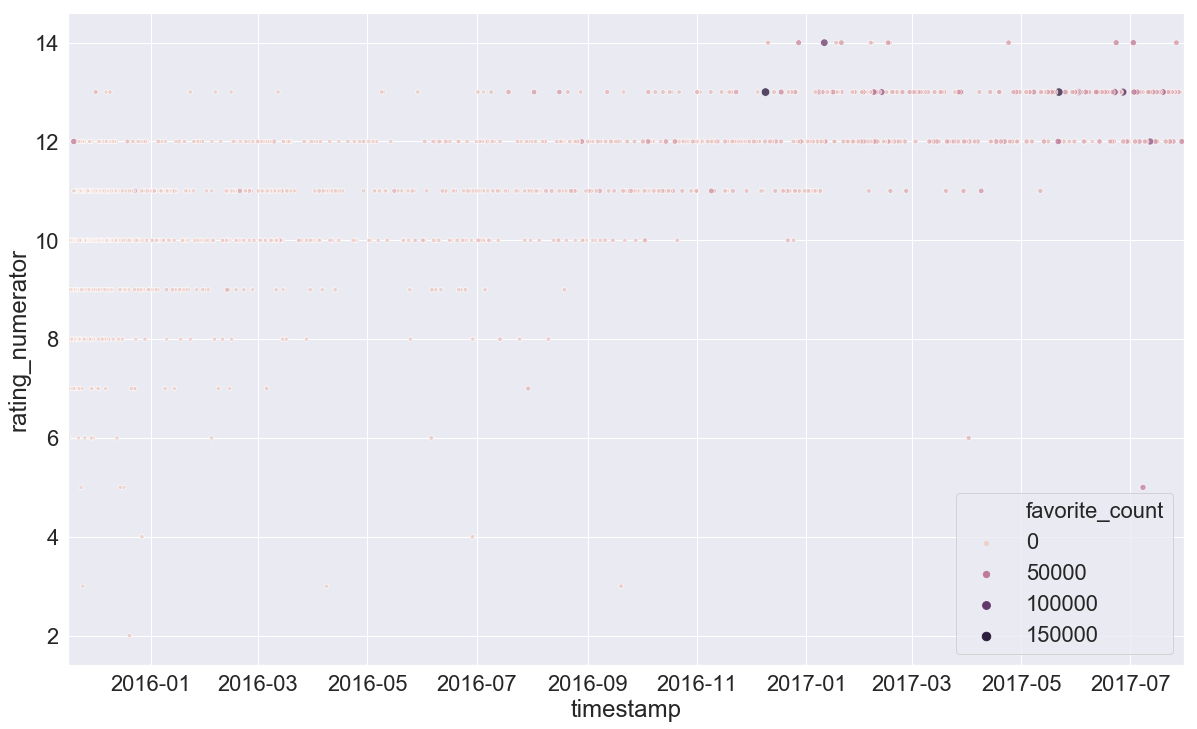

In [245]:
ax = sns.scatterplot(x="timestamp", y="rating_numerator",
                      hue="favorite_count", size="favorite_count",alpha=.8,
                      data=df)

ax.set_xlim(df['timestamp'].min(), df['timestamp'].max())
fig = ax.get_figure()
fig.savefig("plots/favorit_rating_over_time_b.png")

If we look at the favorite count and the retweet count in the diagrams above, then we can see, that they might be similar.

### Retweet and Favorite correlation

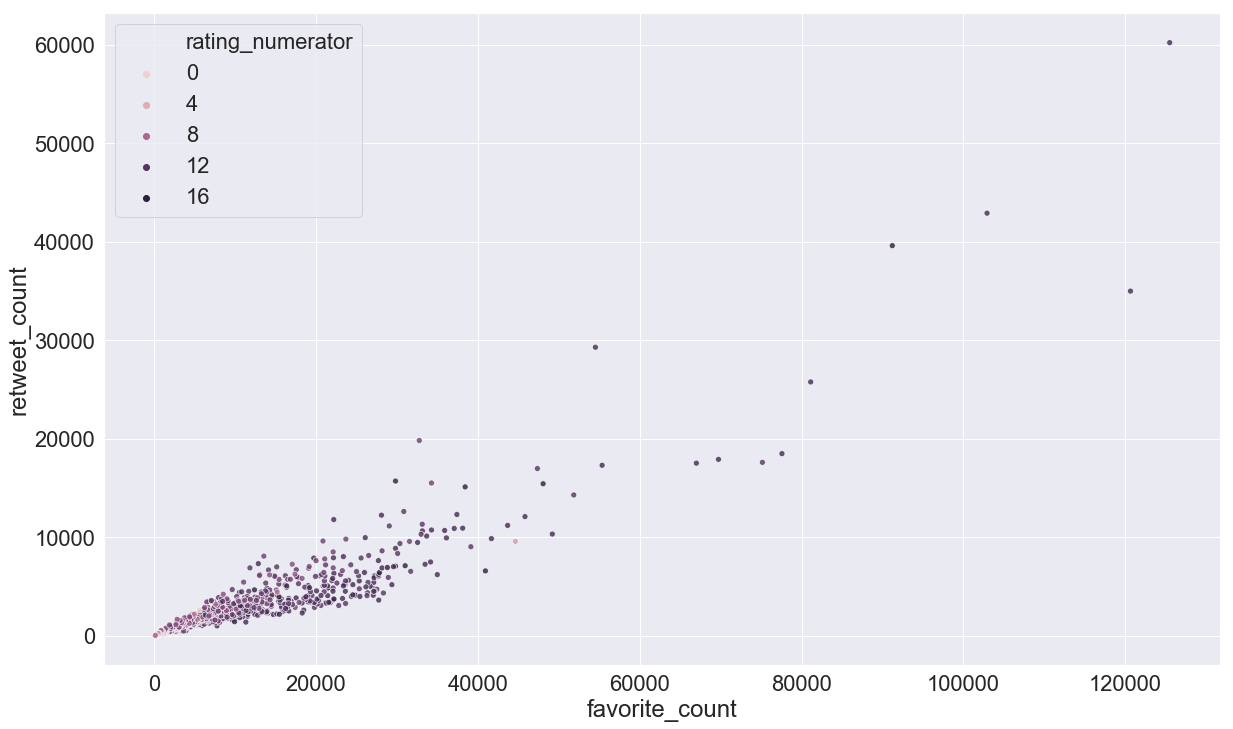

In [246]:
ax = sns.scatterplot(x="favorite_count", y="retweet_count",hue="rating_numerator", 
                     alpha=.8,
                    data=df)
fig = ax.get_figure()
fig.savefig("plots/retweet_favorit_scatter_b.png")

The retweet and favorite count correlate.

### Retweet count over Rating (colored by favorite count)

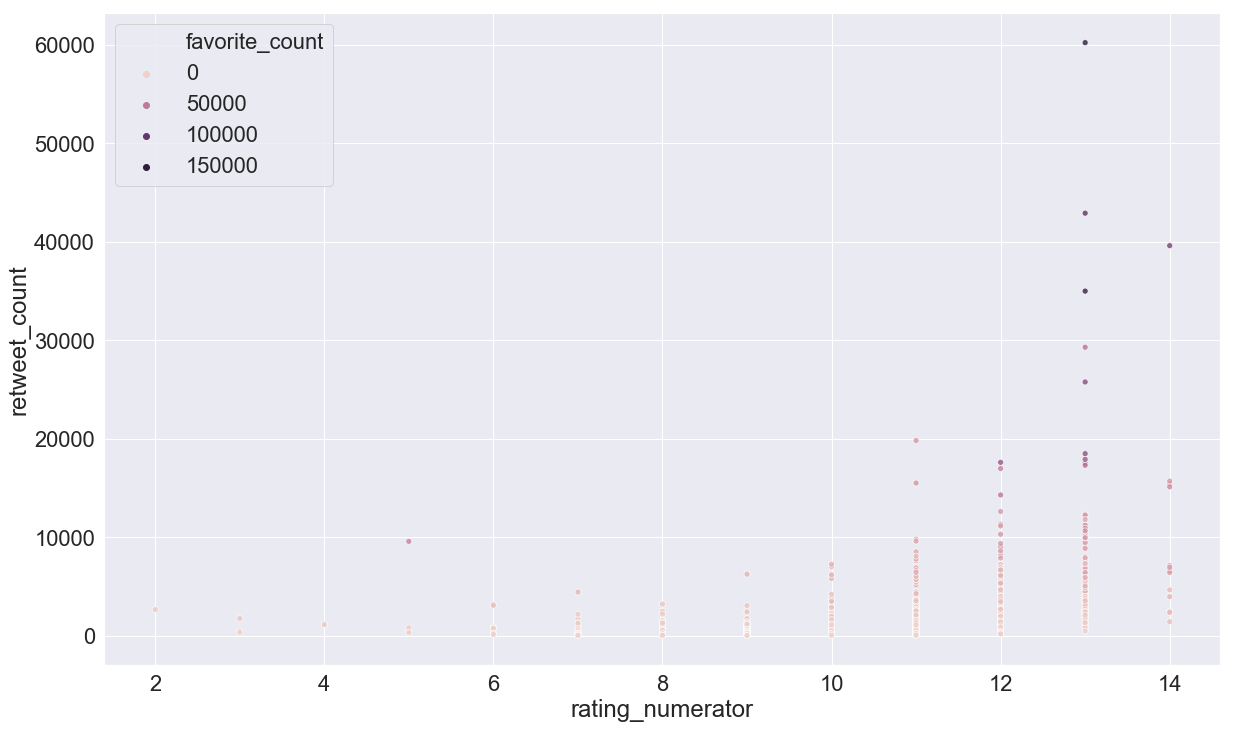

In [247]:
ax = sns.scatterplot(x="rating_numerator", y="retweet_count",hue="favorite_count", 
                     alpha=.8,
                    data=df)
fig = ax.get_figure()
fig.savefig("plots/retweet_rating_scatter_b.png")

The low rating values are not retweeted well. The higher rating values (x-axis) are retweeted more often (y-axis). And also favored more often (color).

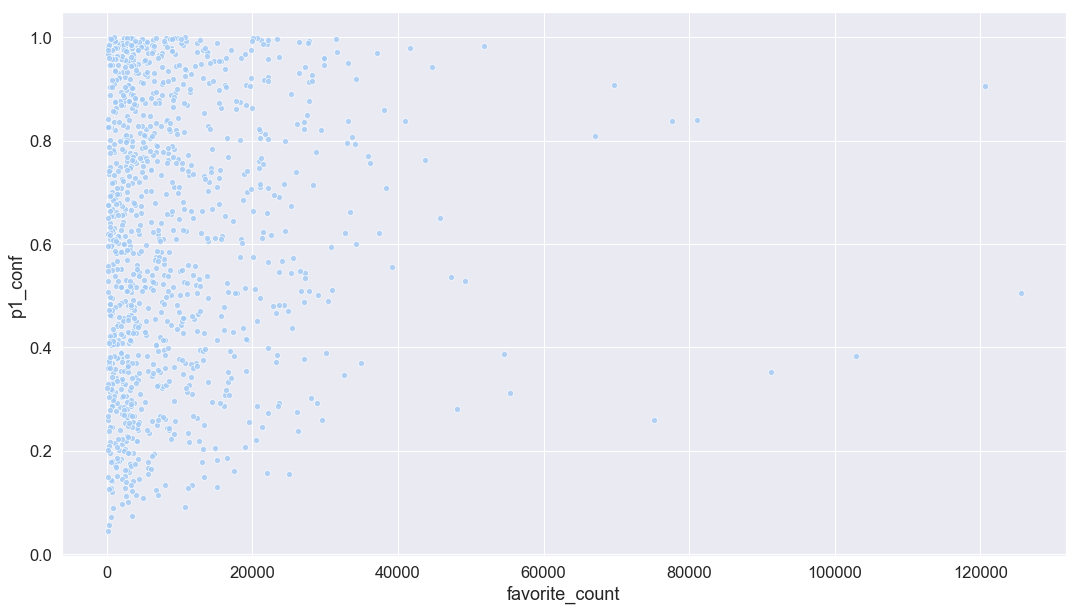

In [235]:
ax = sns.scatterplot(x="favorite_count", y="p1_conf", 
                     alpha=.8,
                    data=df)
fig = ax.get_figure()
fig.savefig("plots/favorite_p1conf_scatter.png")

There is no correlatin between the prediction confidence of the neural network and the favorite count.